# Skillbox ML Junior. Общий файл с поиском моделей и исследованиями.

### XGB: Тестовый AUC: 0.7556 (случайный лес не рассматриваем в поиске по сетке с начальным 0.71, т.к. XGB - более продвинутый вариант леса)
### NN: Тестовый AUC: 0.7532


## 1. Загружаем библиотеки, читаем файл, проверяем и приводим в нормальное состояние


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer #, KNNImputer

from sklearn.model_selection import train_test_split, RandomizedSearchCV
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import pickle

In [5]:
# pip install catboost
# pip install xgboost
# pip install shap matplotlib

In [6]:
from imblearn.under_sampling import RandomUnderSampler

In [7]:
#import catboost
import xgboost as xgb
#from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [8]:
print(xgb.__version__)

3.0.5


In [9]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import copy

In [10]:
# для воспроизводимости один генератор чисел везде
RAND_SEED = 42

In [11]:
#import dask.dataframe as dd #для out-of-core обработки

In [12]:
# смотрим периодически за объемом памяти
import psutil
print(f"Доступно RAM: {psutil.virtual_memory().available / (1024**3):.2f} GB")

Доступно RAM: 6.09 GB


In [13]:
# периодически удаляем из памяти ненужные файлы на определенном этапе
import gc
#сборщик мусора (garbage collector)
#del large_variable
#gc.collect()

In [14]:
import scipy.stats as stats
from sklearn.datasets import make_classification
import warnings
warnings.filterwarnings('ignore')

In [26]:
df = pd.read_parquet('D:/data/data_clean_ohe9f.pq')
with pd.option_context('display.max_columns', None):
    display(df.tail(7))

,id,rn,enc_paym_0_0,enc_paym_0_1,enc_paym_0_2,enc_paym_0_3,enc_paym_1_0,enc_paym_1_1,enc_paym_1_2,enc_paym_1_3,enc_paym_2_0,enc_paym_2_1,enc_paym_2_2,enc_paym_2_3,enc_paym_3_0,enc_paym_3_1,enc_paym_3_2,enc_paym_3_3,enc_paym_4_0,enc_paym_4_1,enc_paym_4_2,enc_paym_4_3,enc_paym_5_0,enc_paym_5_1,enc_paym_5_2,enc_paym_5_3,enc_paym_6_0,enc_paym_6_1,enc_paym_6_2,enc_paym_6_3,enc_paym_7_0,enc_paym_7_1,enc_paym_7_2,enc_paym_7_3,enc_paym_8_0,enc_paym_8_1,enc_paym_8_2,enc_paym_8_3,enc_paym_9_0,enc_paym_9_1,enc_paym_9_2,enc_paym_9_3,enc_paym_10_0,enc_paym_10_1,enc_paym_10_2,enc_paym_10_3,enc_paym_11_1,enc_paym_11_2,enc_paym_11_3,enc_paym_11_4,enc_paym_12_0,enc_paym_12_1,enc_paym_12_2,enc_paym_12_3,enc_paym_13_0,enc_paym_13_1,enc_paym_13_2,enc_paym_13_3,enc_paym_14_0,enc_paym_14_1,enc_paym_14_2,enc_paym_14_3,enc_paym_15_0,enc_paym_15_1,enc_paym_15_2,enc_paym_15_3,enc_paym_16_0,enc_paym_16_1,enc_paym_16_2,enc_paym_16_3,enc_paym_17_0,enc_paym_17_1,enc_paym_17_2,enc_paym_17_3,enc_paym_18_0,enc_paym_18_1,enc_paym_18_2,enc_paym_18_3,enc_paym_19_0,enc_paym_19_1,enc_paym_19_2,enc_paym_19_3,enc_paym_20_1,enc_paym_20_2,enc_paym_20_3,enc_paym_20_4,enc_paym_21_0,enc_paym_21_1,enc_paym_21_2,enc_paym_21_3,enc_paym_22_0,enc_paym_22_1,enc_paym_22_2,enc_paym_22_3,enc_paym_23_0,enc_paym_23_1,enc_paym_23_2,enc_paym_23_3,enc_paym_24_1,enc_paym_24_2,enc_paym_24_3,enc_paym_24_4,enc_loans_account_holder_type_0,enc_loans_account_holder_type_1,enc_loans_account_holder_type_2,enc_loans_account_holder_type_3,enc_loans_account_holder_type_4,enc_loans_account_holder_type_5,enc_loans_account_holder_type_6,enc_loans_credit_status_0,enc_loans_credit_status_1,enc_loans_credit_status_2,enc_loans_credit_status_3,enc_loans_credit_status_4,enc_loans_credit_status_5,enc_loans_credit_status_6,enc_loans_credit_type_0,enc_loans_credit_type_1,enc_loans_credit_type_2,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_account_cur_0,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_3,pre_util_0,pre_util_1,pre_util_2,pre_util_3,pre_util_4,pre_util_5,pre_util_6,pre_util_7,pre_util_8,pre_util_9,pre_util_10,pre_util_11,pre_util_12,pre_util_13,pre_util_14,pre_util_15,pre_util_16,pre_util_17,pre_util_18,pre_util_19,pre_over2limit_0,pre_over2limit_1,pre_over2limit_2,pre_over2limit_3,pre_over2limit_4,pre_over2limit_5,pre_over2limit_6,pre_over2limit_7,pre_over2limit_8,pre_over2limit_9,pre_over2limit_10,pre_over2limit_11,pre_over2limit_12,pre_over2limit_13,pre_over2limit_14,pre_over2limit_15,pre_over2limit_16,pre_over2limit_17,pre_over2limit_18,pre_over2limit_19,pre_maxover2limit_0,pre_maxover2limit_1,pre_maxover2limit_2,pre_maxover2limit_3,pre_maxover2limit_4,pre_maxover2limit_5,pre_maxover2limit_6,pre_maxover2limit_7,pre_maxover2limit_8,pre_maxover2limit_9,pre_maxover2limit_10,pre_maxover2limit_11,pre_maxover2limit_12,pre_maxover2limit_13,pre_maxover2limit_14,pre_maxover2limit_15,pre_maxover2limit_16,pre_maxover2limit_17,pre_maxover2limit_18,pre_maxover2limit_19,pre_loans_credit_limit_0,pre_loans_credit_limit_1,pre_loans_credit_limit_2,pre_loans_credit_limit_3,pre_loans_credit_limit_4,pre_loans_credit_limit_5,pre_loans_credit_limit_6,pre_loans_credit_limit_7,pre_loans_credit_limit_8,pre_loans_credit_limit_9,pre_loans_credit_limit_10,pre_loans_credit_limit_11,pre_loans_credit_limit_12,pre_loans_credit_limit_13,pre_loans_credit_limit_14,pre_loans_credit_limit_15,pre_loans_credit_limit_16,pre_loans_credit_limit_17,pre_loans_credit_limit_18,pre_loans_credit_limit_19,pre_loans_next_pay_summ_0,pre_loans_next_pay_summ_1,pre_loans_next_pay_summ_2,pre_loans_next_pay_summ_3,pre_loans_next_pay_summ_4,pre_loans_next_pay_summ_5,pre_loans_next_pay_summ_6,pre_loans_credit_cost_rate_0,pre_loans_credit_cost_rate_1,pre_loans_credit_cost_rate_2,pre_loans_credit_cost_rate_3,pre_loans_credit_cost_rate_4,pre_loans_credit_cost_rate_5,pre_loans_credit_cost_rate_6,pre_loans_credit_cost_rate_7,pre_loans_credit_cost_rate_8,pre_loans_credit_cost_rate_9,pre_loans_credi

In [16]:
print(f' РАЗМЕР\n {df.shape}')
print(f' ОБЩАЯ ИНФО\n {df.info()}')
print(f' БАЛАНС ПО ЦЕЛЕВОЙ\n {df.flag.value_counts()}')

 РАЗМЕР
 (3000000, 257)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 257 entries, id to flag
dtypes: float32(19), int16(227), int32(1), int64(1), int8(9)
memory usage: 1.5 GB
 ОБЩАЯ ИНФО
 None
 БАЛАНС ПО ЦЕЛЕВОЙ
 flag
0    2893558
1     106442
Name: count, dtype: int64


In [17]:
# ДО ПРЕОБРАЗОВАНИЯ В ПАЙПЛАЙНЕ ЕСТЬ ПРОПУСКИ
df.isna().sum().max() == 0

False

In [18]:
# две колонки имеют пропуски после OHE
with pd.option_context('display.max_rows', None):
    print(f' ЗАПОЛНЕННОСТЬ\n {df.isna().sum().sort_values(ascending=False)}')

 ЗАПОЛНЕННОСТЬ
 enc_loans_credit_type_7            1000000
enc_loans_credit_type_6            1000000
id                                       0
pre_maxover2limit_3                      0
pre_maxover2limit_8                      0
pre_maxover2limit_7                      0
pre_maxover2limit_6                      0
pre_maxover2limit_5                      0
pre_maxover2limit_4                      0
pre_maxover2limit_1                      0
pre_maxover2limit_2                      0
pre_maxover2limit_10                     0
pre_maxover2limit_0                      0
pre_over2limit_19                        0
pre_over2limit_18                        0
pre_over2limit_17                        0
pre_maxover2limit_9                      0
pre_maxover2limit_12                     0
pre_maxover2limit_11                     0
pre_over2limit_15                        0
pre_maxover2limit_13                     0
pre_maxover2limit_14                     0
pre_maxover2limit_15                  

In [19]:
# Найдём столбцы с типом bool
bool_cols = df.select_dtypes(include='bool').columns
# Преобразуем их в int8 
df[bool_cols] = df[bool_cols].astype('int8')

In [20]:
# Найдем столбцы типа object
object_cols = df.select_dtypes(include='object').columns
object_cols

Index([], dtype='object')

In [21]:
# при наличии object
for col in object_cols:
    # Приведём к нижнему регистру и заменим 'true'/'false' на булевы значения
    if df[col].dropna().isin(['True', 'False', 'true', 'false']).all():
        df[col] = df[col].str.capitalize().map({'True': 1, 'False': 0}).astype('int8')
    else:
        # Если не логические строки — попробуем привести к числу (осторожно!)
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype('int8')

In [22]:
# Заполняем ВСЕ пропущенные значения нулями В ИСХОДНОМ ДАТАФРЕЙМЕ СРАЗУ
df.fillna(0, inplace=True)

In [23]:
df.isna().sum().max() == 0

True

In [24]:
# Проверку на inf также проводим (возможно сразу исправить в файле по чтению данных)
inf_cols = []
for col in df.columns:
    if df[col].dtype in ['float32', 'float64']:
        if np.isinf(df[col]).any():
            inf_cols.append(col)
            print(f"Колонка {col} содержит inf")

print("Колонки с inf:", inf_cols)

Колонки с inf: []


In [25]:
print(f' ОБЩАЯ ИНФО\n {df.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 257 entries, id to flag
dtypes: float32(19), int16(227), int32(1), int64(1), int8(9)
memory usage: 1.5 GB
 ОБЩАЯ ИНФО
 None


## 2. Новые фичи после агрегации

In [27]:
# Для каждого месяца — "средний статус" (чем выше, тем хуже)
for month in range(0, 25):  # у нас до 24
    cols = [f'enc_paym_{month}_{i}' for i in range(5) if f'enc_paym_{month}_{i}' in df.columns]
    if cols:
        # Взвешенная сумма: предполагаем, что индекс = уровень риска
        weights = list(range(len(cols)))  # [0,1,2,3,4]
        df[f'paym_score_{month}'] = sum(df[col] * w for col, w in zip(cols, weights))

# Общая оценка платежей
df['avg_payment_score'] = df[[f'paym_score_{m}' for m in range(25) if f'paym_score_{m}' in df.columns]].mean(axis=1)
df['recent_payment_score'] = df[['paym_score_0', 'paym_score_1', 'paym_score_2']].mean(axis=1)
df['payment_trend'] = df['paym_score_0'] - df['paym_score_12']  # ухудшение за год

In [28]:
# Утилизация × количество кредитов пока не используем (достаточно) 
#df['util_x_rn'] = df['pre_util'] * df['rn']

In [29]:
#3 Клиент "чистый"
df['is_perfect'] = (
    (df['is_zero_loans5'] == 1) &
    (df['is_zero_loans530'] == 1) &
    (df['is_zero_loans3060'] == 1) &
    (df['is_zero_loans6090'] == 1) &
    (df['is_zero_loans90'] == 1) &
    (df['is_zero_util'] == 1) # & (df['pre_loans_total_overdue'] == 0)
).astype('int8')

#4 Клиент "рисковый" 
#df['is_high_risk'] = ((df['is_zero_loans90'] == 0) | ((df['is_zero_util'] == 0) & (df['is_zero_over2limit'] == 0) & (df['is_zero_maxover2limit'] == 0))).astype('int8')

In [30]:
credit_type_cols = [col for col in df.columns if col.startswith('enc_loans_credit_type_')]
df['num_credit_types'] = df[credit_type_cols].sum(axis=1)  # сколько типов кредитов у клиента
# Интенсивность кредитования ВРЕМЕННЫЕ
df['loans_per_time'] = df['rn'] / (df['pre_since_opened'] + 1)  # кредитов на день истории

In [31]:
# ВСПОМНИМ КОЛОНКИ ИЗ ЧТЕНИЯ - новые фичи и rn отдельная группировка
new_cols = ['total_outstanding', 'weighted_late_score'] #'total_credit_limit', 'total_late_payments', 'total_util_ratio',
new_pay_cols = df.filter(like='paym_score_').columns.tolist() 
new_in_cols = ['avg_payment_score','recent_payment_score','payment_trend','is_perfect','num_credit_types','loans_per_time'] #,'is_high_risk'] #,'util_x_rn','is_high_risk']
new_age_cols = ['loan_age'] #, 'loan_age_ratio']
max_cols = ['rn']  
  
date_cols = ['pre_pterm', 'pre_fterm', 'pre_till_pclose', 'pre_till_fclose', 'pre_since_opened', 'pre_since_confirmed']

# КАТЕГОРИАЛЬНЫЕ    
abs_sum_cols1 = ['pre_loans_credit_limit', 'pre_loans_next_pay_summ', 'pre_loans_credit_cost_rate']
ratio_cols = ['pre_util', 'pre_over2limit', 'pre_maxover2limit']  
cat_cols = ['enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9',
             'enc_paym_10', 'enc_paym_11', 'enc_paym_12', 'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16', 'enc_paym_17', 'enc_paym_18',
             'enc_paym_19', 'enc_paym_20', 'enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24',
             'enc_loans_account_holder_type', 'enc_loans_credit_status', 'enc_loans_credit_type', 'enc_loans_account_cur']
# НЕ КАТЕГОРИАЛЬНЫЕ В КОРРЕЛЯЦИИ
num_overdues = ['pre_loans5', 'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90'] # корреляция кроме 6090 с weighted_late_score ????? 
abs_sum_cols2 = ['pre_loans_outstanding', 'pre_loans_total_overdue', 'pre_loans_max_overdue_sum']
 #ФЛАГИ - ПРОПУСКАЕМ эти фичи     
flag_cols = ['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90',
             'is_zero_util', 'is_zero_over2limit', 'is_zero_maxover2limit']   
date_flag_cols = ['pclose_flag', 'fclose_flag']

ohe_cols = cat_cols + ratio_cols + abs_sum_cols1 # эти колонки пошли в OHE
ohe_cat_cols = [col for col in df.columns if col.startswith(tuple([f"{c}_" for c in ohe_cols]))]

# для даньнейшей работы в моделях
features1 = new_cols + new_in_cols + new_age_cols + max_cols + date_cols + ohe_cat_cols + num_overdues + abs_sum_cols2 + flag_cols + date_flag_cols + new_pay_cols
target = 'flag'

In [32]:
features = df.columns.tolist()

In [33]:
# проверим количество признаков в группах
print(set(features) - set(features1))

{'id', 'flag'}


In [34]:
# Проверка на inf после новых фичей на всякий случай
inf_cols = []
for col in df.columns:
    if df[col].dtype in ['float32', 'float64']:
        if np.isinf(df[col]).any():
            inf_cols.append(col)
            print(f"Колонка {col} содержит inf")

print("Колонки с inf:", inf_cols)

Колонки с inf: []


In [35]:
# После заполнения уменьшим объем памяти
df[ohe_cat_cols] = df[ohe_cat_cols].astype('uint8')

In [36]:
# еще раз проверим на 0
df.isna().sum().max() == 0

True

In [37]:
int64col = df.select_dtypes(include=['int64']).columns
int64col.tolist()

['flag']

In [38]:
#уменьшаем размерность
for col in df.select_dtypes(include=['float64']).columns:
    df[col] = df[col].astype('float32')
for col in df.select_dtypes(include=['int64']).columns:
    df[col] = df[col].astype('int8')

In [39]:
print(f' ОБЩАЯ ИНФО\n {df.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 288 entries, id to loans_per_time
dtypes: float32(21), int16(28), int32(1), int8(11), uint8(227)
memory usage: 1.1 GB
 ОБЩАЯ ИНФО
 None


### ДАЛЕЕ проводим анализ

In [102]:
df.weighted_late_score.value_counts()

weighted_late_score
218     218511
109     215861
327     213970
436     205225
545     192465
         ...  
3075         1
3235         1
2700         1
4133         1
3988         1
Name: count, Length: 3567, dtype: int64

In [94]:
df.total_util_ratio.value_counts()

total_util_ratio
0.333333    45039
0.250000    31746
0.300000    28638
0.285714    26771
0.250000    23589
            ...  
0.245077        1
0.299505        1
0.864407        1
0.488506        1
0.245238        1
Name: count, Length: 13016, dtype: int64

In [96]:
df.enc_loans_credit_type_7.value_counts()

enc_loans_credit_type_7
0     2756470
1      195874
2       35956
3        7881
4        2185
5         821
6         352
7         195
8         103
9          75
10         40
11         28
12          8
13          6
14          5
15          1
Name: count, dtype: int64

In [33]:
df['enc_loans_credit_type_6'].sum()

5013.8003

In [82]:
# Доля дефолтов среди кредитов типа 6 ОСТАВЛЯЕМ!!!
default_rate_type6 = df[df['enc_loans_credit_type_6'] == 1]['flag'].mean()
# Общая доля дефолтов
default_rate_all = df['flag'].mean()
print(f"Тип 6: {default_rate_type6:.3f} vs Общая: {default_rate_all:.3f}")

Тип 6: 0.044 vs Общая: 0.035


In [84]:
# Доля дефолтов среди кредитов типа 7
default_rate_type7 = df[df['enc_loans_credit_type_7'] == 1]['flag'].mean()
print(f"Тип 7: {default_rate_type7:.3f} vs Общая: {default_rate_all:.3f}")

Тип 7: 0.035 vs Общая: 0.035


In [94]:
# Доля дефолтов среди кредитов total_util_ratio
total_outstanding7 = df[df['total_outstanding'] == 1]['flag'].mean()
print(f"total_outstanding7: {total_outstanding7:.3f} vs Общая: {default_rate_all:.3f}")

total_outstanding7: 0.032 vs Общая: 0.035


<Axes: >

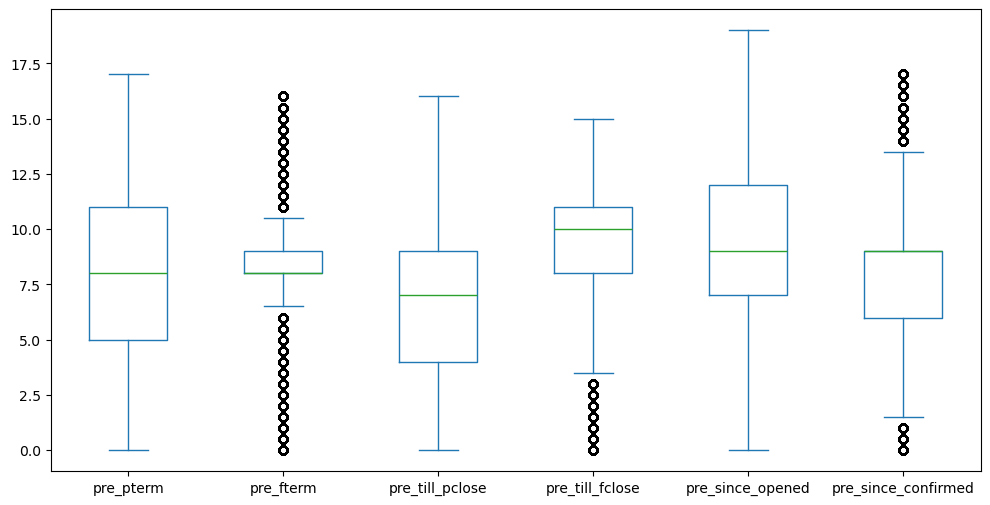

In [65]:
df[date_cols].plot(kind='box', figsize=(12,6))

In [66]:
df[df['pre_loans_total_overdue']==1] # возможно неправильная подготовка или выброс - убрать тогда

,id,enc_paym_0_0,enc_paym_0_1,enc_paym_0_2,enc_paym_0_3,enc_paym_1_0,enc_paym_1_1,enc_paym_1_2,enc_paym_1_3,enc_paym_2_0,...,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pclose_flag,fclose_flag,enc_loans_credit_type_6,enc_loans_credit_type_7,flag
1947962,1447962,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Histogram for pre_pterm


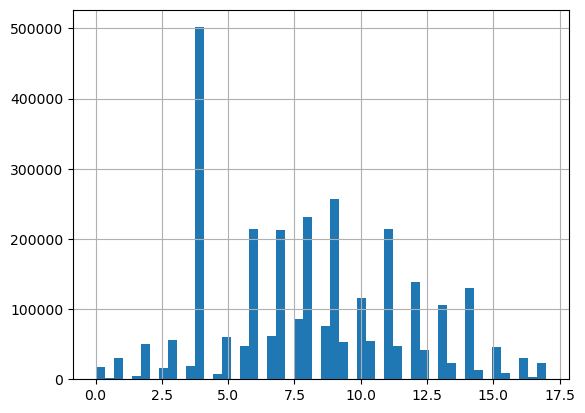

Histogram for pre_fterm


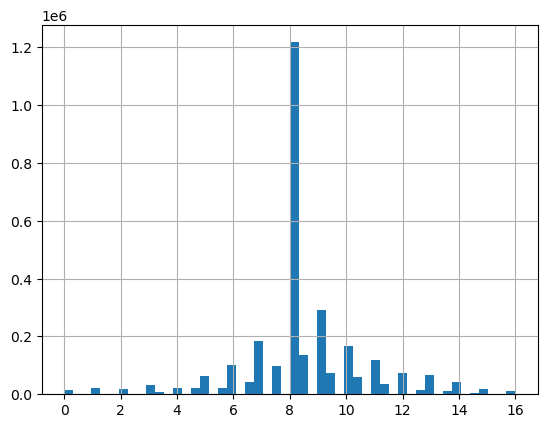

Histogram for pre_till_pclose


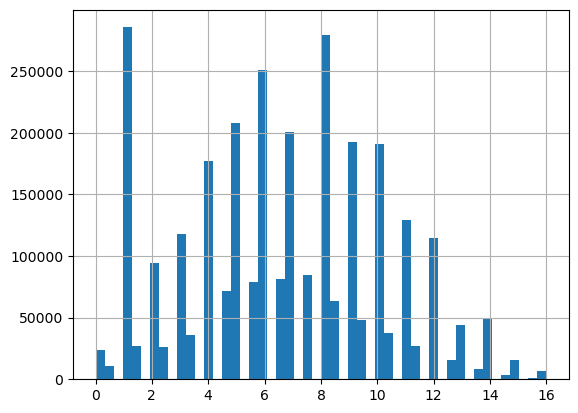

Histogram for pre_till_fclose


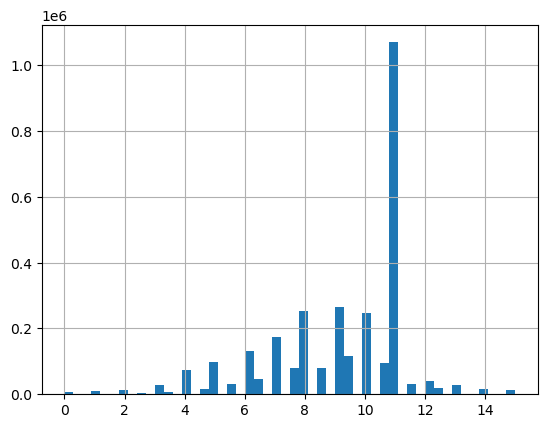

Histogram for pre_since_opened


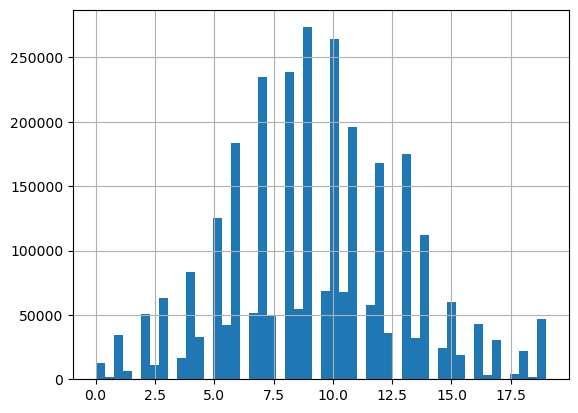

Histogram for pre_since_confirmed


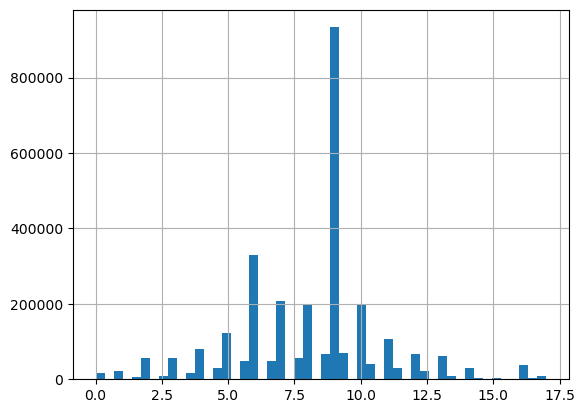

In [70]:
# ГРАФИКИ ДЛЯ АНАЛИЗА ДАТАСЕТА
num_cols = new_cols
for col in num_cols:
  print(f'Histogram for {col}')
  df[col].hist(bins=50)
  plt.show()

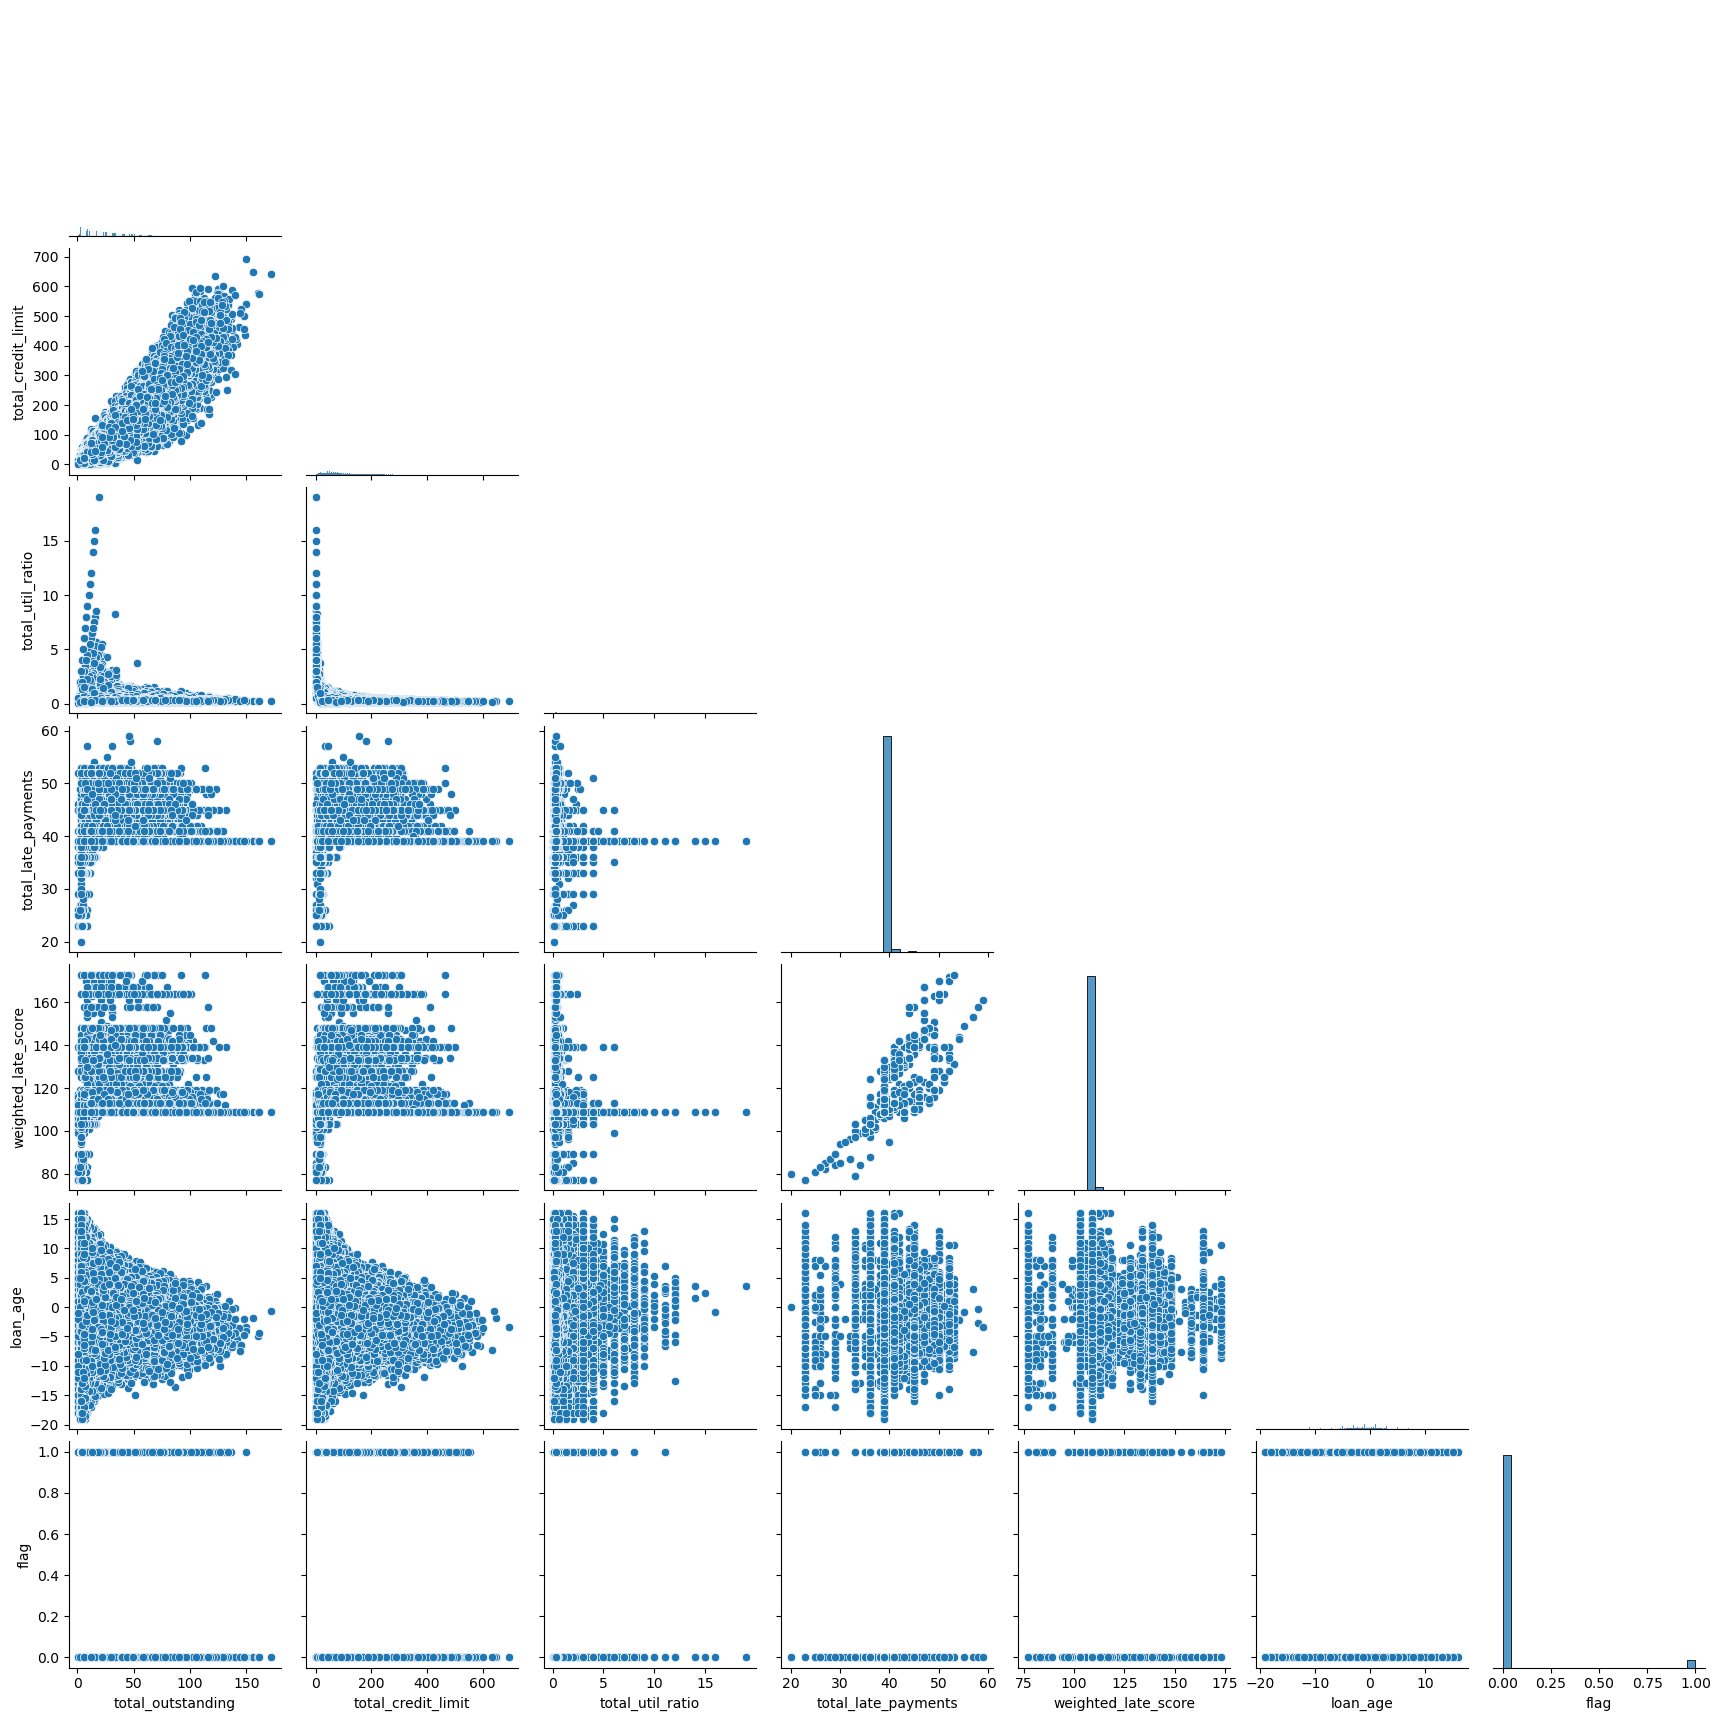

In [41]:
sns.pairplot(df[new_cols+['flag']], diag_kind="auto", corner=True)
plt.show()

In [1]:
#col_m1 = [col for col in df.columns if col.startswith("pre_over2limit_")]

In [ ]:
# КОНЕЦ АНАЛИЗУ!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

## 3. Подготовка пайплайна

In [75]:
# удаляем ненужные колонки, которые коррелированы или не несут информацию
col_m1 = [col for col in df.columns if col.startswith("pre_over2limit_")]
col_m2 = [col for col in df.columns if col.startswith('pre_maxover2limit_')]
df=df.drop(columns=col_m1+col_m2, axis=1)

In [79]:
# id удаляем также
df=df.drop(columns=['id'], axis=1) 

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 247 entries, rn to loans_per_time
dtypes: float32(21), int16(28), int8(11), uint8(187)
memory usage: 967.0 MB


In [82]:
# ОБЩИЙ ФАЙЛ  с разными скалерами
features = df.columns.tolist()
target = 'flag'

df_train, df_test = train_test_split(df, stratify=df[target], test_size=0.2, random_state=RAND_SEED) 

# готовим веса и делаем балансировку в самой модели
class_weights = {
    0: 1,
    1: (df_train[df_train[target] == 0].shape[0] / df_train[df_train[target] == 1].shape[0]) #* 2 # ** 2
}

# выделяем из тренировочной и тестовой выборок целевые
X_train, y_train = df_train[features], df_train[target]
X_test, y_test = df_test[features], df_test[target]

# DOWNSAMPLING не используем, но его применять ТОЛЬКО к train!
#rus = RandomUnderSampler(random_state=RAND_SEED) # DOWNSAMPLING
#X_res, y_res = rus.fit_resample(X_train, y_train)# DOWNSAMPLING

# сократим тип данных до float32 или 16 для различных скалеров
class StandardScaler32(StandardScaler):
    def transform(self, X, copy=None):
        return super().transform(X, copy).astype(np.float32)
    
    def fit_transform(self, X, y=None, **fit_params):
        return super().fit_transform(X, y, **fit_params).astype(np.float32)
        
class StandardScaler16(StandardScaler):
    def transform(self, X, copy=None):
        return super().transform(X, copy).astype(np.float16)
    
    def fit_transform(self, X, y=None, **fit_params):
        return super().fit_transform(X, y, **fit_params).astype(np.float16)
        
class MinMaxScaler32(MinMaxScaler): # пробуем разные скалеры
    def transform(self, X, *args, **kwargs):
        return super().transform(X, *args, **kwargs).astype(np.float32)

class MinMaxScaler16(MinMaxScaler): # пробуем разные скалеры
    def transform(self, X, *args, **kwargs):
        return super().transform(X, *args, **kwargs).astype(np.float16)

In [84]:
# СОБСТВЕННО ПАЙПЛАЙН ДЛЯ NN И XGB, ДЛЯ CATBOOST ОТДЕЛЬНО
ohe_cat_cols = [col for col in df.columns if col.startswith(tuple([f"{c}_" for c in ohe_cols]))]
# ohe_cols = cat_cols + ratio_cols + abs_sum_cols1
ct = ColumnTransformer(
    transformers=[
        # Числовые признаки (без ohe_cols!)
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', MinMaxScaler32()) # попробуем со склалером на 32, т.к. нейросеть по 32 работает, но можно уменьшить и до 16
        ]), new_cols + new_age_cols + max_cols + date_cols + new_in_cols + num_overdues + abs_sum_cols2 + new_pay_cols + ohe_cat_cols),
        
        # Флаги и OHE-признаки — просто передаём как есть
        ('passthrough', 'passthrough', flag_cols + date_flag_cols)
    ],
    remainder='drop'
)
#features1 = new_cols + new_in_cols + new_age_cols + max_cols + date_cols + ohe_cat_cols + median_cols2 + sum_cols2 + flag_cols + date_flag_cols

pipeline = Pipeline([
    ('preprocessor', ct),
    ('classifier', XGBClassifier(
        random_state=RAND_SEED,
        eval_metric='auc',
        scale_pos_weight=class_weights[1], # DOWNSAMPLING 0
        learning_rate=0.01, #0.05
        max_depth=6, #4
        n_estimators=700, #500
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=5,
        gamma=0.1,
        reg_lambda=2,
        use_label_encoder=False,
        verbosity=0
    ))
])

In [91]:
# ЗАПУСК ПАЙПЛАЙНА!!!!!!!!!!!!!
pipeline.fit(X_train, y_train)  # передаём ИСХОДНЫЕ X_train # DOWNSAMPLING
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_pred_proba))

# Данные полученные ранее
#0.7066813969703972 без балансировки по обычным
# 0.7097623032602473 балансировка
# по новому преобразованию 04 0.7136571798381783
# ohe на подготовке 0.7314587700821567
# downsampling 0.7300405832385369
# с новыми фичами 0.731392208538074 без двух последних
# OHE с увеличенным количеством фичей на чтении 0.7522395716048882, 0.7524069175395259 0.7526536251278668 
# SS16 - 0.7525252556761759 MM16 - 0.7527894737462937 0.7503493487324355

0.7503071178474403


In [98]:
# ПОСМОТРИМ НА исходный до преобразования в ПАЙПЛАЙНЕ
with pd.option_context('display.max_columns', None):
    display(X_train.head(10))

,rn,enc_paym_0_0,enc_paym_0_1,enc_paym_0_2,enc_paym_0_3,enc_paym_1_0,enc_paym_1_1,enc_paym_1_2,enc_paym_1_3,enc_paym_2_0,enc_paym_2_1,enc_paym_2_2,enc_paym_2_3,enc_paym_3_0,enc_paym_3_1,enc_paym_3_2,enc_paym_3_3,enc_paym_4_0,enc_paym_4_1,enc_paym_4_2,enc_paym_4_3,enc_paym_5_0,enc_paym_5_1,enc_paym_5_2,enc_paym_5_3,enc_paym_6_0,enc_paym_6_1,enc_paym_6_2,enc_paym_6_3,enc_paym_7_0,enc_paym_7_1,enc_paym_7_2,enc_paym_7_3,enc_paym_8_0,enc_paym_8_1,enc_paym_8_2,enc_paym_8_3,enc_paym_9_0,enc_paym_9_1,enc_paym_9_2,enc_paym_9_3,enc_paym_10_0,enc_paym_10_1,enc_paym_10_2,enc_paym_10_3,enc_paym_11_1,enc_paym_11_2,enc_paym_11_3,enc_paym_11_4,enc_paym_12_0,enc_paym_12_1,enc_paym_12_2,enc_paym_12_3,enc_paym_13_0,enc_paym_13_1,enc_paym_13_2,enc_paym_13_3,enc_paym_14_0,enc_paym_14_1,enc_paym_14_2,enc_paym_14_3,enc_paym_15_0,enc_paym_15_1,enc_paym_15_2,enc_paym_15_3,enc_paym_16_0,enc_paym_16_1,enc_paym_16_2,enc_paym_16_3,enc_paym_17_0,enc_paym_17_1,enc_paym_17_2,enc_paym_17_3,enc_paym_18_0,enc_paym_18_1,enc_paym_18_2,enc_paym_18_3,enc_paym_19_0,enc_paym_19_1,enc_paym_19_2,enc_paym_19_3,enc_paym_20_1,enc_paym_20_2,enc_paym_20_3,enc_paym_20_4,enc_paym_21_0,enc_paym_21_1,enc_paym_21_2,enc_paym_21_3,enc_paym_22_0,enc_paym_22_1,enc_paym_22_2,enc_paym_22_3,enc_paym_23_0,enc_paym_23_1,enc_paym_23_2,enc_paym_23_3,enc_paym_24_1,enc_paym_24_2,enc_paym_24_3,enc_paym_24_4,enc_loans_account_holder_type_0,enc_loans_account_holder_type_1,enc_loans_account_holder_type_2,enc_loans_account_holder_type_3,enc_loans_account_holder_type_4,enc_loans_account_holder_type_5,enc_loans_account_holder_type_6,enc_loans_credit_status_0,enc_loans_credit_status_1,enc_loans_credit_status_2,enc_loans_credit_status_3,enc_loans_credit_status_4,enc_loans_credit_status_5,enc_loans_credit_status_6,enc_loans_credit_type_0,enc_loans_credit_type_1,enc_loans_credit_type_2,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_account_cur_0,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_3,pre_util_0,pre_util_1,pre_util_2,pre_util_3,pre_util_4,pre_util_5,pre_util_6,pre_util_7,pre_util_8,pre_util_9,pre_util_10,pre_util_11,pre_util_12,pre_util_13,pre_util_14,pre_util_15,pre_util_16,pre_util_17,pre_util_18,pre_util_19,pre_over2limit_0,pre_over2limit_1,pre_over2limit_2,pre_over2limit_3,pre_over2limit_4,pre_over2limit_5,pre_over2limit_6,pre_over2limit_7,pre_over2limit_8,pre_over2limit_9,pre_over2limit_10,pre_over2limit_11,pre_over2limit_12,pre_over2limit_13,pre_over2limit_14,pre_over2limit_15,pre_over2limit_16,pre_over2limit_17,pre_over2limit_18,pre_over2limit_19,pre_maxover2limit_0,pre_maxover2limit_1,pre_maxover2limit_2,pre_maxover2limit_3,pre_maxover2limit_4,pre_maxover2limit_5,pre_maxover2limit_6,pre_maxover2limit_7,pre_maxover2limit_8,pre_maxover2limit_9,pre_maxover2limit_10,pre_maxover2limit_11,pre_maxover2limit_12,pre_maxover2limit_13,pre_maxover2limit_14,pre_maxover2limit_15,pre_maxover2limit_16,pre_maxover2limit_17,pre_maxover2limit_18,pre_maxover2limit_19,pre_loans_credit_limit_0,pre_loans_credit_limit_1,pre_loans_credit_limit_2,pre_loans_credit_limit_3,pre_loans_credit_limit_4,pre_loans_credit_limit_5,pre_loans_credit_limit_6,pre_loans_credit_limit_7,pre_loans_credit_limit_8,pre_loans_credit_limit_9,pre_loans_credit_limit_10,pre_loans_credit_limit_11,pre_loans_credit_limit_12,pre_loans_credit_limit_13,pre_loans_credit_limit_14,pre_loans_credit_limit_15,pre_loans_credit_limit_16,pre_loans_credit_limit_17,pre_loans_credit_limit_18,pre_loans_credit_limit_19,pre_loans_next_pay_summ_0,pre_loans_next_pay_summ_1,pre_loans_next_pay_summ_2,pre_loans_next_pay_summ_3,pre_loans_next_pay_summ_4,pre_loans_next_pay_summ_5,pre_loans_next_pay_summ_6,pre_loans_credit_cost_rate_0,pre_loans_credit_cost_rate_1,pre_loans_credit_cost_rate_2,pre_loans_credit_cost_rate_3,pre_loans_credit_cost_rate_4,pre_loans_credit_cost_rate_5,pre_loans_credit_cost_rate_6,pre_loans_credit_cost_rate_7,pre_loans_credit_cost_rate_8,pre_loans_credit_cost_rate_9,pre_loans_credit_c

In [100]:
X_train.shape

(2400000, 290)

In [102]:
X_train.info() # на входе тип данных оптимальный

<class 'pandas.core.frame.DataFrame'>
Index: 2400000 entries, 2305221 to 1588343
Columns: 290 entries, rn to loans_per_time
dtypes: float32(23), int16(28), int8(12), uint8(227)
memory usage: 904.1 MB


## 4.Ручное преобразование (без пайплайна) для других моделей

In [89]:
#ОСВОБОДИМ ПАМЯТЬ
# Больше не нужен — удаляем
del df
gc.collect()  # ← явно просим освободить память

0

In [91]:
# РУЧНОЕ ПРЕОБРАЗОВАНИЕ
X_transformed = ct.fit_transform(X_train) # потом только transform к новым данным (валидация и тест)
feature_names = ct.get_feature_names_out()
clean_names = [name.split('__')[1] for name in feature_names]
X_train_transf = pd.DataFrame(X_transformed, columns=clean_names)

X_test_transform = ct.transform(X_test) # потом только transform к новым данным (валидация и тест)
X_test_transf = pd.DataFrame(X_test_transform, columns=clean_names)

In [92]:
# ПОСЛЕ ПРОЕБРАЗОВАНИЯ В ПАЙПЛАЙНЕ НЕТ ПРОПУСКОВ
X_train_transf.isna().sum().max() == 0

True

In [100]:
# ПОСЛЕ РУЧНОГО преобразования
with pd.option_context('display.max_columns', None):
    display(X_train_transf.head(10))

,total_outstanding,total_util_ratio,weighted_late_score,loan_age,loan_age_ratio,rn,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_since_opened,pre_since_confirmed,avg_payment_score,recent_payment_score,payment_trend,is_perfect,num_credit_types,loans_per_time,is_high_risk,pre_loans5,pre_loans530,pre_loans3060,pre_loans6090,pre_loans90,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,paym_score_0,paym_score_1,paym_score_2,paym_score_3,paym_score_4,paym_score_5,paym_score_6,paym_score_7,paym_score_8,paym_score_9,paym_score_10,paym_score_11,paym_score_12,paym_score_13,paym_score_14,paym_score_15,paym_score_16,paym_score_17,paym_score_18,paym_score_19,paym_score_20,paym_score_21,paym_score_22,paym_score_23,paym_score_24,enc_paym_0_0,enc_paym_0_1,enc_paym_0_2,enc_paym_0_3,enc_paym_1_0,enc_paym_1_1,enc_paym_1_2,enc_paym_1_3,enc_paym_2_0,enc_paym_2_1,enc_paym_2_2,enc_paym_2_3,enc_paym_3_0,enc_paym_3_1,enc_paym_3_2,enc_paym_3_3,enc_paym_4_0,enc_paym_4_1,enc_paym_4_2,enc_paym_4_3,enc_paym_5_0,enc_paym_5_1,enc_paym_5_2,enc_paym_5_3,enc_paym_6_0,enc_paym_6_1,enc_paym_6_2,enc_paym_6_3,enc_paym_7_0,enc_paym_7_1,enc_paym_7_2,enc_paym_7_3,enc_paym_8_0,enc_paym_8_1,enc_paym_8_2,enc_paym_8_3,enc_paym_9_0,enc_paym_9_1,enc_paym_9_2,enc_paym_9_3,enc_paym_10_0,enc_paym_10_1,enc_paym_10_2,enc_paym_10_3,enc_paym_11_1,enc_paym_11_2,enc_paym_11_3,enc_paym_11_4,enc_paym_12_0,enc_paym_12_1,enc_paym_12_2,enc_paym_12_3,enc_paym_13_0,enc_paym_13_1,enc_paym_13_2,enc_paym_13_3,enc_paym_14_0,enc_paym_14_1,enc_paym_14_2,enc_paym_14_3,enc_paym_15_0,enc_paym_15_1,enc_paym_15_2,enc_paym_15_3,enc_paym_16_0,enc_paym_16_1,enc_paym_16_2,enc_paym_16_3,enc_paym_17_0,enc_paym_17_1,enc_paym_17_2,enc_paym_17_3,enc_paym_18_0,enc_paym_18_1,enc_paym_18_2,enc_paym_18_3,enc_paym_19_0,enc_paym_19_1,enc_paym_19_2,enc_paym_19_3,enc_paym_20_1,enc_paym_20_2,enc_paym_20_3,enc_paym_20_4,enc_paym_21_0,enc_paym_21_1,enc_paym_21_2,enc_paym_21_3,enc_paym_22_0,enc_paym_22_1,enc_paym_22_2,enc_paym_22_3,enc_paym_23_0,enc_paym_23_1,enc_paym_23_2,enc_paym_23_3,enc_paym_24_1,enc_paym_24_2,enc_paym_24_3,enc_paym_24_4,enc_loans_account_holder_type_0,enc_loans_account_holder_type_1,enc_loans_account_holder_type_2,enc_loans_account_holder_type_3,enc_loans_account_holder_type_4,enc_loans_account_holder_type_5,enc_loans_account_holder_type_6,enc_loans_credit_status_0,enc_loans_credit_status_1,enc_loans_credit_status_2,enc_loans_credit_status_3,enc_loans_credit_status_4,enc_loans_credit_status_5,enc_loans_credit_status_6,enc_loans_credit_type_0,enc_loans_credit_type_1,enc_loans_credit_type_2,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_account_cur_0,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_3,pre_util_0,pre_util_1,pre_util_2,pre_util_3,pre_util_4,pre_util_5,pre_util_6,pre_util_7,pre_util_8,pre_util_9,pre_util_10,pre_util_11,pre_util_12,pre_util_13,pre_util_14,pre_util_15,pre_util_16,pre_util_17,pre_util_18,pre_util_19,pre_loans_credit_limit_0,pre_loans_credit_limit_1,pre_loans_credit_limit_2,pre_loans_credit_limit_3,pre_loans_credit_limit_4,pre_loans_credit_limit_5,pre_loans_credit_limit_6,pre_loans_credit_limit_7,pre_loans_credit_limit_8,pre_loans_credit_limit_9,pre_loans_credit_limit_10,pre_loans_credit_limit_11,pre_loans_credit_limit_12,pre_loans_credit_limit_13,pre_loans_credit_limit_14,pre_loans_credit_limit_15,pre_loans_credit_limit_16,pre_loans_credit_limit_17,pre_loans_credit_limit_18,pre_loans_credit_limit_19,pre_loans_next_pay_summ_0,pre_loans_next_pay_summ_1,pre_loans_next_pay_summ_2,pre_loans_next_pay_summ_3,pre_loans_next_pay_summ_4,pre_loans_next_pay_summ_5,pre_loans_next_pay_summ_6,pre_loans_credit_cost_rate_0,pre_loans_credit_cost_rate_1,pre_loans_credit_cost_rate_2,pre_loans_credit_cost_rate_3,pre_loans_credit_cost_rate_4,pre_loans_credit_cost_rate_5,pre_loans_credit_cost_rate_6,pre_loans_credit_cost_rate_7,pre_loans_credit_cost_rate_8,pre_loans_credit_cost_rate_9,pre_loans_credit_cost_rat

In [97]:
# ПОСЛЕ РУЧНОГО преобразования
with pd.option_context('display.max_columns', None):
    display(X_train_transf.describe())

,total_outstanding,total_util_ratio,weighted_late_score,loan_age,loan_age_ratio,rn,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_since_opened,pre_since_confirmed,avg_payment_score,recent_payment_score,payment_trend,is_perfect,num_credit_types,loans_per_time,is_high_risk,pre_loans5,pre_loans530,pre_loans3060,pre_loans6090,pre_loans90,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,paym_score_0,paym_score_1,paym_score_2,paym_score_3,paym_score_4,paym_score_5,paym_score_6,paym_score_7,paym_score_8,paym_score_9,paym_score_10,paym_score_11,paym_score_12,paym_score_13,paym_score_14,paym_score_15,paym_score_16,paym_score_17,paym_score_18,paym_score_19,paym_score_20,paym_score_21,paym_score_22,paym_score_23,paym_score_24,enc_paym_0_0,enc_paym_0_1,enc_paym_0_2,enc_paym_0_3,enc_paym_1_0,enc_paym_1_1,enc_paym_1_2,enc_paym_1_3,enc_paym_2_0,enc_paym_2_1,enc_paym_2_2,enc_paym_2_3,enc_paym_3_0,enc_paym_3_1,enc_paym_3_2,enc_paym_3_3,enc_paym_4_0,enc_paym_4_1,enc_paym_4_2,enc_paym_4_3,enc_paym_5_0,enc_paym_5_1,enc_paym_5_2,enc_paym_5_3,enc_paym_6_0,enc_paym_6_1,enc_paym_6_2,enc_paym_6_3,enc_paym_7_0,enc_paym_7_1,enc_paym_7_2,enc_paym_7_3,enc_paym_8_0,enc_paym_8_1,enc_paym_8_2,enc_paym_8_3,enc_paym_9_0,enc_paym_9_1,enc_paym_9_2,enc_paym_9_3,enc_paym_10_0,enc_paym_10_1,enc_paym_10_2,enc_paym_10_3,enc_paym_11_1,enc_paym_11_2,enc_paym_11_3,enc_paym_11_4,enc_paym_12_0,enc_paym_12_1,enc_paym_12_2,enc_paym_12_3,enc_paym_13_0,enc_paym_13_1,enc_paym_13_2,enc_paym_13_3,enc_paym_14_0,enc_paym_14_1,enc_paym_14_2,enc_paym_14_3,enc_paym_15_0,enc_paym_15_1,enc_paym_15_2,enc_paym_15_3,enc_paym_16_0,enc_paym_16_1,enc_paym_16_2,enc_paym_16_3,enc_paym_17_0,enc_paym_17_1,enc_paym_17_2,enc_paym_17_3,enc_paym_18_0,enc_paym_18_1,enc_paym_18_2,enc_paym_18_3,enc_paym_19_0,enc_paym_19_1,enc_paym_19_2,enc_paym_19_3,enc_paym_20_1,enc_paym_20_2,enc_paym_20_3,enc_paym_20_4,enc_paym_21_0,enc_paym_21_1,enc_paym_21_2,enc_paym_21_3,enc_paym_22_0,enc_paym_22_1,enc_paym_22_2,enc_paym_22_3,enc_paym_23_0,enc_paym_23_1,enc_paym_23_2,enc_paym_23_3,enc_paym_24_1,enc_paym_24_2,enc_paym_24_3,enc_paym_24_4,enc_loans_account_holder_type_0,enc_loans_account_holder_type_1,enc_loans_account_holder_type_2,enc_loans_account_holder_type_3,enc_loans_account_holder_type_4,enc_loans_account_holder_type_5,enc_loans_account_holder_type_6,enc_loans_credit_status_0,enc_loans_credit_status_1,enc_loans_credit_status_2,enc_loans_credit_status_3,enc_loans_credit_status_4,enc_loans_credit_status_5,enc_loans_credit_status_6,enc_loans_credit_type_0,enc_loans_credit_type_1,enc_loans_credit_type_2,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_account_cur_0,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_3,pre_util_0,pre_util_1,pre_util_2,pre_util_3,pre_util_4,pre_util_5,pre_util_6,pre_util_7,pre_util_8,pre_util_9,pre_util_10,pre_util_11,pre_util_12,pre_util_13,pre_util_14,pre_util_15,pre_util_16,pre_util_17,pre_util_18,pre_util_19,pre_loans_credit_limit_0,pre_loans_credit_limit_1,pre_loans_credit_limit_2,pre_loans_credit_limit_3,pre_loans_credit_limit_4,pre_loans_credit_limit_5,pre_loans_credit_limit_6,pre_loans_credit_limit_7,pre_loans_credit_limit_8,pre_loans_credit_limit_9,pre_loans_credit_limit_10,pre_loans_credit_limit_11,pre_loans_credit_limit_12,pre_loans_credit_limit_13,pre_loans_credit_limit_14,pre_loans_credit_limit_15,pre_loans_credit_limit_16,pre_loans_credit_limit_17,pre_loans_credit_limit_18,pre_loans_credit_limit_19,pre_loans_next_pay_summ_0,pre_loans_next_pay_summ_1,pre_loans_next_pay_summ_2,pre_loans_next_pay_summ_3,pre_loans_next_pay_summ_4,pre_loans_next_pay_summ_5,pre_loans_next_pay_summ_6,pre_loans_credit_cost_rate_0,pre_loans_credit_cost_rate_1,pre_loans_credit_cost_rate_2,pre_loans_credit_cost_rate_3,pre_loans_credit_cost_rate_4,pre_loans_credit_cost_rate_5,pre_loans_credit_cost_rate_6,pre_loans_credit_cost_rate_7,pre_loans_credit_cost_rate_8,pre_loans_credit_cost_rate_9,pre_loans_credit_cost_rat

In [95]:
# Проверим X_train_transf и y_train
print("NaN в X_train:", X_train_transf.isna().sum().sum())
print("Inf в X_train:", np.isinf(X_train_transf.values).sum())
print("NaN в y_train:", y_train.isna().sum())
print("Уникальные значения y_train:", np.unique(y_train))
print("Мин/макс X_train:", X_train_transf.min().min(), X_train_transf.max().max())

NaN в X_train: 0
Inf в X_train: 0
NaN в y_train: 0
Уникальные значения y_train: [0 1]
Мин/макс X_train: 0.0 1.0


In [97]:
X_train_transf.info() # после преобразования ct, кот используется для пайплайна

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400000 entries, 0 to 2399999
Columns: 246 entries, total_outstanding to fclose_flag
dtypes: float32(246)
memory usage: 2.2 GB


## 5. Ищем оптимальные параметры для XGB

In [99]:
print(f"Доступно RAM: {psutil.virtual_memory().available / (1024**3):.2f} GB")

Доступно RAM: 5.21 GB


In [116]:
# Определяем распределения параметров для случайного поиска
param_distributions = {
    # Основные параметры
    'max_depth': stats.randint(3, 6),           # от 3 до 9
    'learning_rate': stats.uniform(0.01, 0.3),   # от 0.01 до 0.31
    'subsample': stats.uniform(0.6, 0.4),        # от 0.6 до 1.0
    'colsample_bytree': stats.uniform(0.6, 0.4), # от 0.6 до 1.0
    
    # Регуляризация
    'reg_alpha': stats.expon(scale=1),           # от 0 до ~10
    'reg_lambda': stats.expon(scale=1.5),        # от 0 до ~15
    
    # Дополнительные
    'min_child_weight': stats.randint(1, 10),    # от 1 до 9
    'gamma': stats.uniform(0, 0.5)               # от 0 до 0.5
}

print("Диапазоны параметров для поиска:")
for param, dist in param_distributions.items():
    if hasattr(dist, 'rvs'):
        samples = dist.rvs(size=5, random_state=RAND_SEED)
        print(f"{param}: {samples}")

Диапазоны параметров для поиска:
max_depth: [5 3 5 5 3]
learning_rate: [0.12236204 0.29521429 0.22959818 0.18959755 0.05680559]
subsample: [0.74981605 0.98028572 0.89279758 0.83946339 0.66240746]
colsample_bytree: [0.74981605 0.98028572 0.89279758 0.83946339 0.66240746]
reg_alpha: [0.46926809 3.01012143 1.31674569 0.91294255 0.16962487]
reg_lambda: [0.70390213 4.51518215 1.97511854 1.36941383 0.25443731]
min_child_weight: [7 4 8 5 7]
gamma: [0.18727006 0.47535715 0.36599697 0.29932924 0.07800932]


In [118]:
# Базовая модель с настройками для экономии памяти
base_model = xgb.XGBClassifier(
    n_estimators=1000,           # Много деревьев + early stopping потом
    random_state=RAND_SEED,
    eval_metric='auc',
    scale_pos_weight=class_weights[1],
    use_label_encoder=False,
    tree_method='hist',          # Экономит память
    verbosity=0
)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=20,                   # Всего 20 случайных комбинаций
    scoring='roc_auc',
    cv=2,                        # 3 фолда (можно уменьшить до 2 при нехватке памяти)
    n_jobs=1,                    # Одно ядро, один процесс для экономии памяти
    random_state=RAND_SEED,
    verbose=1,
    refit=True                   # Переобучим лучшую модель на всех данных
)


In [120]:
# 1.RandomizedSearchCV БЕЗ ранней остановки
print("Запуск RandomizedSearchCV (без early stopping)...")
random_search.fit(X_train_transf, y_train)  # ← никаких доп. аргументов!

Запуск RandomizedSearchCV (без early stopping)...
Fitting 2 folds for each of 20 candidates, totalling 40 fits


RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrai...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001EFC0FB0D10>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001EFC0F7A000>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001EFEB253830>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001EFE14A23C0>},
                   random_state=42, scoring='roc_auc', verbose=1)

In [122]:
best_params = random_search.best_params_
best_params
#{'colsample_bytree': 0.6783931449676581,
# 'learning_rate': 0.02356818667316142,
# 'max_depth': 7,
# 'subsample': 0.7554709158757928}

{'colsample_bytree': 0.8916028672163949,
 'gamma': 0.38563517334297287,
 'learning_rate': 0.03221339552022711,
 'max_depth': 5,
 'min_child_weight': 9,
 'reg_alpha': 2.4646297296191846,
 'reg_lambda': 2.846065804843518,
 'subsample': 0.7797802696552814}

In [118]:
print("XGBoost version:", xgb.__version__)
#{'colsample_bytree': 0.7007129183301457,
# 'gamma': 0.24862425294619273,
# 'learning_rate': 0.1002634929450309,
# 'max_depth': 3,
# 'min_child_weight': 8,
# 'reg_alpha': 0.03758447776552253,
# 'reg_lambda': 1.4107381064738898,
# 'subsample': 0.8010716092915446}

#{'colsample_bytree': 0.8916028672163949,
# 'gamma': 0.38563517334297287,
# 'learning_rate': 0.03221339552022711,
# 'max_depth': 5,
# 'min_child_weight': 9,
# 'reg_alpha': 2.4646297296191846,
# 'reg_lambda': 2.846065804843518,
# 'subsample': 0.7797802696552814}

XGBoost version: 3.0.5


In [124]:
# 2. После поиска — лучшие параметры и добавим early stopping вручную
best_params['n_estimators'] = 1000  # или больше

final_model = xgb.XGBClassifier(
    **best_params,
    random_state=RAND_SEED,
    eval_metric='auc',
    scale_pos_weight=class_weights[1],
    use_label_encoder=False,
    tree_method='hist',
    verbosity=0
)
# Разделение данных для ранней остановки
X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train_transf, y_train, test_size=0.2, random_state=RAND_SEED, stratify=y_train
)
# Обучим финальную модель с ранней остановкой
final_model.fit(
    X_train_part, y_train_part,
    eval_set=[(X_val, y_val)],
    #callbacks=[xgb.callback.EarlyStopping(rounds=50, save_best=True)],
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8916028672163949, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=0.38563517334297287, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03221339552022711,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, ...)

In [126]:
results = final_model.evals_result()
val_auc = results['validation_0']['auc']
print(f"Лучший AUC на валидации: {max(val_auc):.4f}")

Лучший AUC на валидации: 0.7524


In [134]:
# Лучшие параметры и score
print("\n" + "="*50)
print("РЕЗУЛЬТАТЫ RANDOMIZEDSEARCHCV")
print("="*50)
print(f"Лучшие параметры: {random_search.best_params_}")
print(f"Лучший CV score: {random_search.best_score_:.4f}")

# Оценка на тестовой выборке
best_model = random_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test_transf)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Тестовый AUC: {test_auc:.4f}")

# Детальный анализ всех попыток
results_df = pd.DataFrame(random_search.cv_results_)
print(f"\nВсего испытано комбинаций: {len(results_df)}")


РЕЗУЛЬТАТЫ RANDOMIZEDSEARCHCV
Лучшие параметры: {'colsample_bytree': 0.8916028672163949, 'gamma': 0.38563517334297287, 'learning_rate': 0.03221339552022711, 'max_depth': 5, 'min_child_weight': 9, 'reg_alpha': 2.4646297296191846, 'reg_lambda': 2.846065804843518, 'subsample': 0.7797802696552814, 'n_estimators': 1000}
Лучший CV score: 0.7522
Тестовый AUC: 0.7556

Всего испытано комбинаций: 20


#### ЗАПОМНИМ: РЕЗУЛЬТАТЫ RANDOMIZEDSEARCHCV
==================================================
Лучшие параметры: {'colsample_bytree': 0.7007129183301457, 'gamma': 0.24862425294619273, 'learning_rate': 0.1002634929450309, 'max_depth': 3, 'min_child_weight': 8, 'reg_alpha': 0.03758447776552253, 'reg_lambda': 1.4107381064738898, 'subsample': 0.8010716092915446, 'n_estimators': 1000}
Лучший CV score: 0.7506
Тестовый AUC: 0.7536

Всего испытано комбинаций: 20


==================================================
РЕЗУЛЬТАТЫ RANDOMIZEDSEARCHCV
==================================================
Лучшие параметры: {'colsample_bytree': 0.8916028672163949, 'gamma': 0.38563517334297287, 'learning_rate': 0.03221339552022711, 'max_depth': 5, 'min_child_weight': 9, 'reg_alpha': 2.4646297296191846, 'reg_lambda': 2.846065804843518, 'subsample': 0.7797802696552814, 'n_estimators': 1000}
Лучший CV score: 0.7522
Тестовый AUC: 0.7556

Всего испытано комбинаций: 20

In [101]:
# Создаем финальную модель с лучшими параметрами
# чтобы не запускать поиск по сетке выше
best_params = {'colsample_bytree': 0.8916028672163949, 'gamma': 0.38563517334297287, 'learning_rate': 0.03221339552022711, 'max_depth': 5, 'min_child_weight': 9, 'reg_alpha': 2.4646297296191846, 'reg_lambda': 2.846065804843518, 'subsample': 0.7797802696552814, 'n_estimators': 1000}
# Копируем best_params_, чтобы не изменять оригинал
#best_params = random_search.best_params_.copy()

# Удаляем n_estimators из словаря
best_params.pop('n_estimators', None)

final_model = xgb.XGBClassifier(
    **best_params,
    n_estimators=3000,
    random_state=RAND_SEED,
    eval_metric='auc',
    use_label_encoder=False,
    tree_method='hist'
)
# Обучаем на всех тренировочных данных
final_model.fit(
    X_train_transf, y_train,
    eval_set=[(X_test_transf, y_test)],
    #early_stopping_rounds=100,   # Увеличиваем для финальной модели
    verbose=100
)
# Финальная оценка
y_pred_final = final_model.predict(X_test_transf)
y_pred_proba_final = final_model.predict_proba(X_test_transf)[:, 1]

final_auc = roc_auc_score(y_test, y_pred_proba_final)
final_accuracy = (y_pred_final == y_test).mean()

print("\n" + "="*50)
print("ФИНАЛЬНАЯ МОДЕЛЬ")
print("="*50)
print(f"Test AUC: {final_auc:.4f}")
print(f"Test Accuracy: {final_accuracy:.4f}")
print(f"Количество деревьев: {final_model.best_iteration}")

[0]	validation_0-auc:0.66760
[100]	validation_0-auc:0.74020
[200]	validation_0-auc:0.74700
[300]	validation_0-auc:0.75024
[400]	validation_0-auc:0.75210
[500]	validation_0-auc:0.75325
[600]	validation_0-auc:0.75404
[700]	validation_0-auc:0.75469
[800]	validation_0-auc:0.75513
[900]	validation_0-auc:0.75552
[1000]	validation_0-auc:0.75590
[1100]	validation_0-auc:0.75628
[1200]	validation_0-auc:0.75666
[1300]	validation_0-auc:0.75686
[1400]	validation_0-auc:0.75708
[1500]	validation_0-auc:0.75726
[1600]	validation_0-auc:0.75740
[1700]	validation_0-auc:0.75757
[1800]	validation_0-auc:0.75772
[1900]	validation_0-auc:0.75776
[2000]	validation_0-auc:0.75791
[2100]	validation_0-auc:0.75799
[2200]	validation_0-auc:0.75807
[2300]	validation_0-auc:0.75818
[2400]	validation_0-auc:0.75827
[2500]	validation_0-auc:0.75831
[2600]	validation_0-auc:0.75838
[2700]	validation_0-auc:0.75842
[2800]	validation_0-auc:0.75849
[2900]	validation_0-auc:0.75852
[2999]	validation_0-auc:0.75859

ФИНАЛЬНАЯ МОДЕЛЬ
Te

AttributeError: `best_iteration` is only defined when early stopping is used.

[0]	validation_0-auc:0.62361
[100]	validation_0-auc:0.74259
[200]	validation_0-auc:0.74764
[300]	validation_0-auc:0.74967
[400]	validation_0-auc:0.75093
[500]	validation_0-auc:0.75188
[600]	validation_0-auc:0.75248
[700]	validation_0-auc:0.75292
[800]	validation_0-auc:0.75320
[900]	validation_0-auc:0.75359
[999]	validation_0-auc:0.75376

==================================================
ФИНАЛЬНАЯ МОДЕЛЬ
==================================================
Test AUC: 0.7538
Test Accuracy: 0.9645

### Оценка признаков по XGB

In [121]:
# Получить важность по 'gain'
importance_gain = final_model.get_booster().get_score(importance_type='gain')
# Преобразовать в DataFrame
importance_df = pd.DataFrame(list(importance_gain.items()), columns=['feature', 'gain'])
importance_df = importance_df.sort_values('gain', ascending=False)
print(importance_df.head(5))
print(importance_df.tail(20))

                          feature        gain
220  pre_loans_credit_cost_rate_6  168.146744
173                    pre_util_6  106.879135
170                    pre_util_3  105.568573
158       enc_loans_credit_type_0  104.847977
231             is_zero_loans3060   75.563927
                             feature      gain
136                    enc_paym_22_2  6.355471
108                    enc_paym_15_2  6.293044
124                    enc_paym_19_2  6.242329
228          enc_loans_credit_type_7  6.234199
76                      enc_paym_7_2  6.108973
132                    enc_paym_21_2  6.010262
116                    enc_paym_17_2  5.973127
112                    enc_paym_16_2  5.948682
174                       pre_util_7  5.926112
64                      enc_paym_4_2  5.925224
195         pre_loans_credit_limit_8  5.916135
128                    enc_paym_20_3  5.796555
14                  num_credit_types  5.647764
120                    enc_paym_18_2  5.317359
17                 

<Figure size 1400x1800 with 0 Axes>

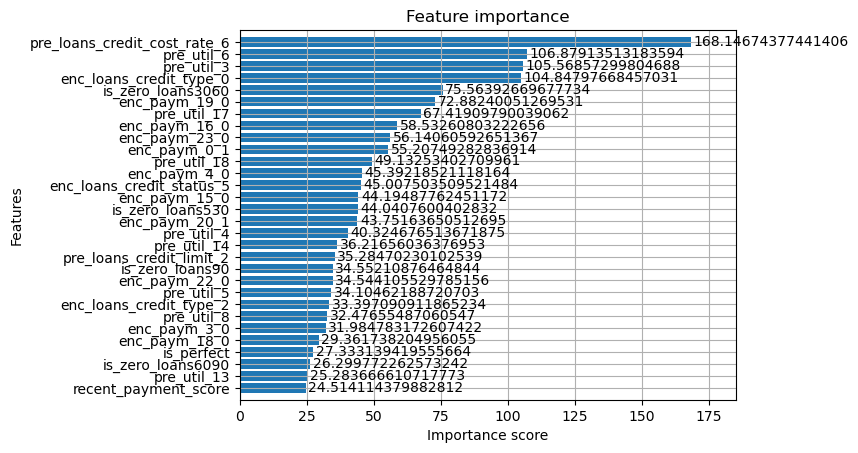

<Figure size 2000x2400 with 0 Axes>

In [125]:
plt.figure(figsize=(14, 18))
xgb.plot_importance(final_model, importance_type='gain', max_num_features=30, height=0.8)
plt.figure(figsize=(20, 24))
plt.tight_layout()
plt.show()

## 6. Случайный лес (был испытан ранее)

In [79]:
# Поиск по сетке не проводим, т.к. XGB показывает лучшие результаты
#rf = RandomForestClassifier(random_state=RAND_SEED, class_weight=class_weights)
#params = {'n_estimators': np.arange(90, 120, 10), 'max_depth' : [7, 10, None], 'max_features' : ['sqrt', 'log2', None]} #'criterion' : ['gini', 'entropy'], 
#gs_rf = GridSearchCV(rf, params, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)
#gs_rf.fit(X_train_transf, y_train)

#print('best score на тренировочных:', gs_rf.best_score_)
#print('best params:', gs_rf.best_params_)
#rf2 = gs_rf.best_estimator_
#rf2.fit(X_train_transf, y_train)
#pred2 = rf2.predict(X_test_transf)
#print(f'ROC-AUC на RF после баланса и подбора гиперпараметров: {roc_auc_score(y_test, pred2)}')

In [97]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RAND_SEED)

models = []
metrics = []

X, y = X_train_transf, y_train
print(X.shape, y.shape)

# получение индексов для текущего фолда
for train_index, test_index in kf.split(X, y):
  X_train1, y_train1 = X.values[train_index], y.values[train_index]
  X_test1, y_test1 = X.values[test_index], y.values[test_index]

  model = RandomForestClassifier(n_estimators=120, max_depth=7, random_state=RAND_SEED, class_weight='balanced')

  model.fit(X_train1, y_train1)
  score = roc_auc_score(y_test1, model.predict_proba(X_test1)[:, 1])
  print(score)

  models.append(model)
  metrics.append(score)

(2400000, 249) (2400000,)
0.7161822325708149
0.7115849396541061
0.7156913578054094


In [ ]:
# Данные с другими вариантами чтения файлов паркет
#0.6901814997296659
#0.686612995707843
#0.6892298957148743
#0.7068251545187402
#0.7044688811095317
#0.7093067943200433

In [99]:
# что не учитываем
new_cols = ['total_outstanding','total_util_ratio','weighted_late_score'] #'total_credit_limit', 'total_late_payments',
new_in_cols = ['avg_payment_score','recent_payment_score','payment_trend','is_perfect','num_credit_types','loans_per_time','is_high_risk'] #,'util_x_rn','is_high_risk']
new_age_cols = ['loan_age', 'loan_age_ratio']

In [99]:
# МОЖНО УДАЛЯТЬ проверим в NN!!!!!!!!!!!!!!!!!!
delnew_cols = ['total_util_ratio'] #'total_credit_limit', 'total_late_payments',
delnew_in_cols = ['payment_trend','num_credit_types'] #,'util_x_rn','is_high_risk']
delnew_age_cols = ['loan_age_ratio']

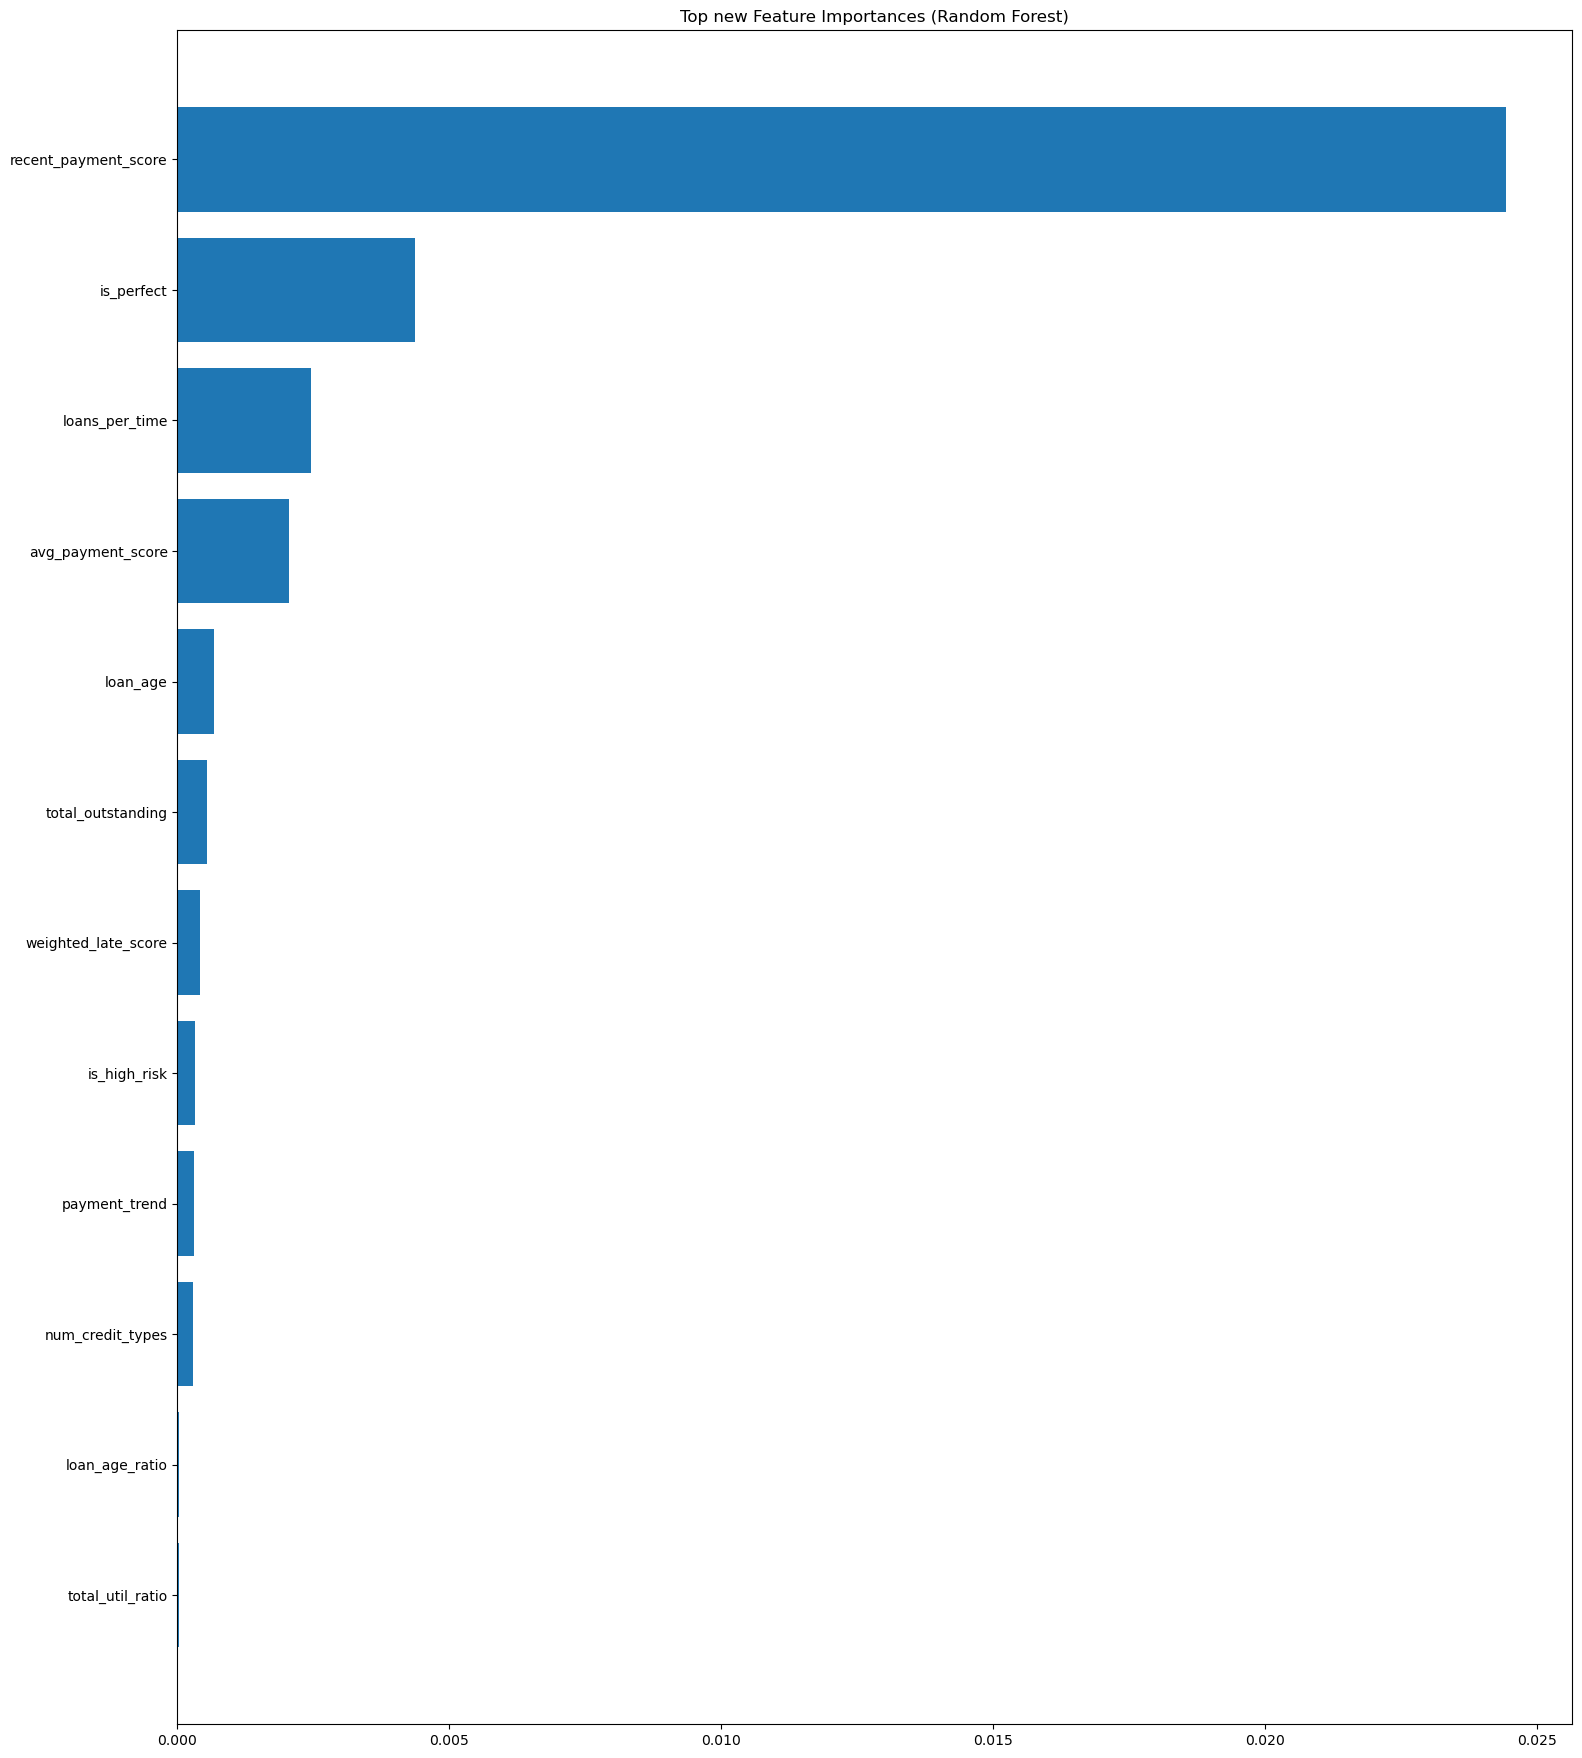

In [101]:
# ПРОВЕРЯЕМ ВАЖНОСТЬ НОВЫХ ФИЧЕЙ
importances = model.feature_importances_
feature_names = X_train_transf.columns
# Создание DataFrame для удобства
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)
feat_imp = feat_imp[feat_imp['feature'].isin(new_cols + new_in_cols + new_age_cols)]
#feat_imp = feat_imp[feat_imp['feature'].str.contains('total_outstanding|total_util_ratio|weighted_late_score', case=False, na=False)]
# Визуализация 
plt.figure(figsize=(14, 18))
plt.barh(feat_imp.head(12)['feature'], feat_imp.head(12)['importance'])
plt.gca().invert_yaxis()
plt.title('Top new Feature Importances (Random Forest)')
plt.savefig('D:/data/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

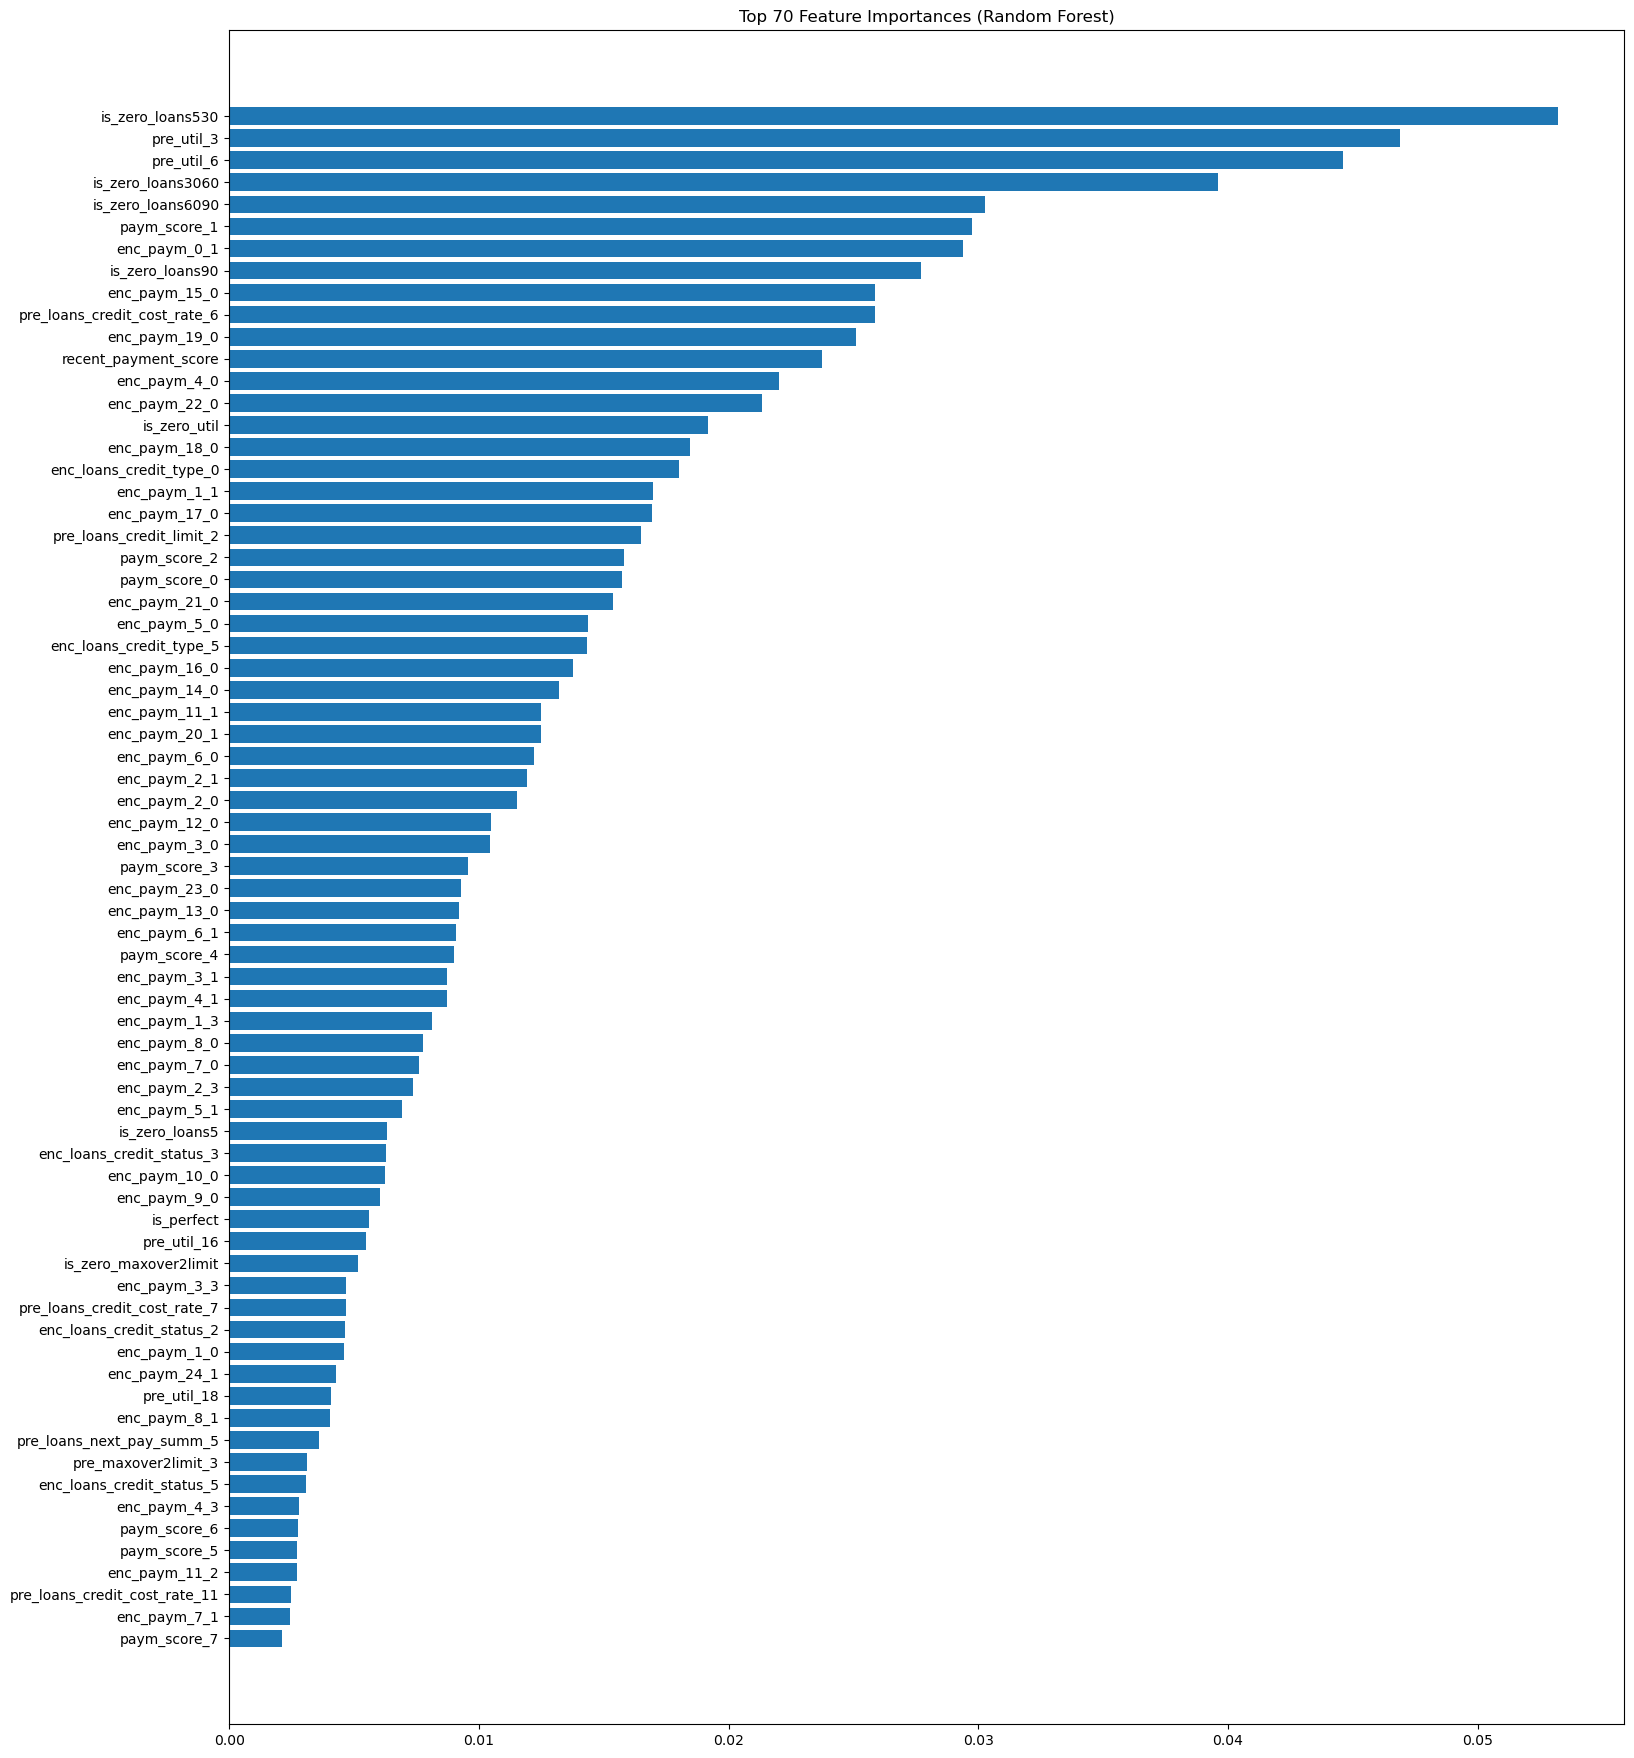

In [125]:
# Получение важностей признаков дерева
importances = model.feature_importances_
feature_names = X_train_transf.columns
# Создание DataFrame для удобства
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)
# Визуализация 
plt.figure(figsize=(18, 22))
plt.barh(feat_imp.head(70)['feature'], feat_imp.head(70)['importance'])
plt.gca().invert_yaxis()
plt.title('Top 70 Feature Importances (Random Forest)')
plt.savefig('D:/data/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

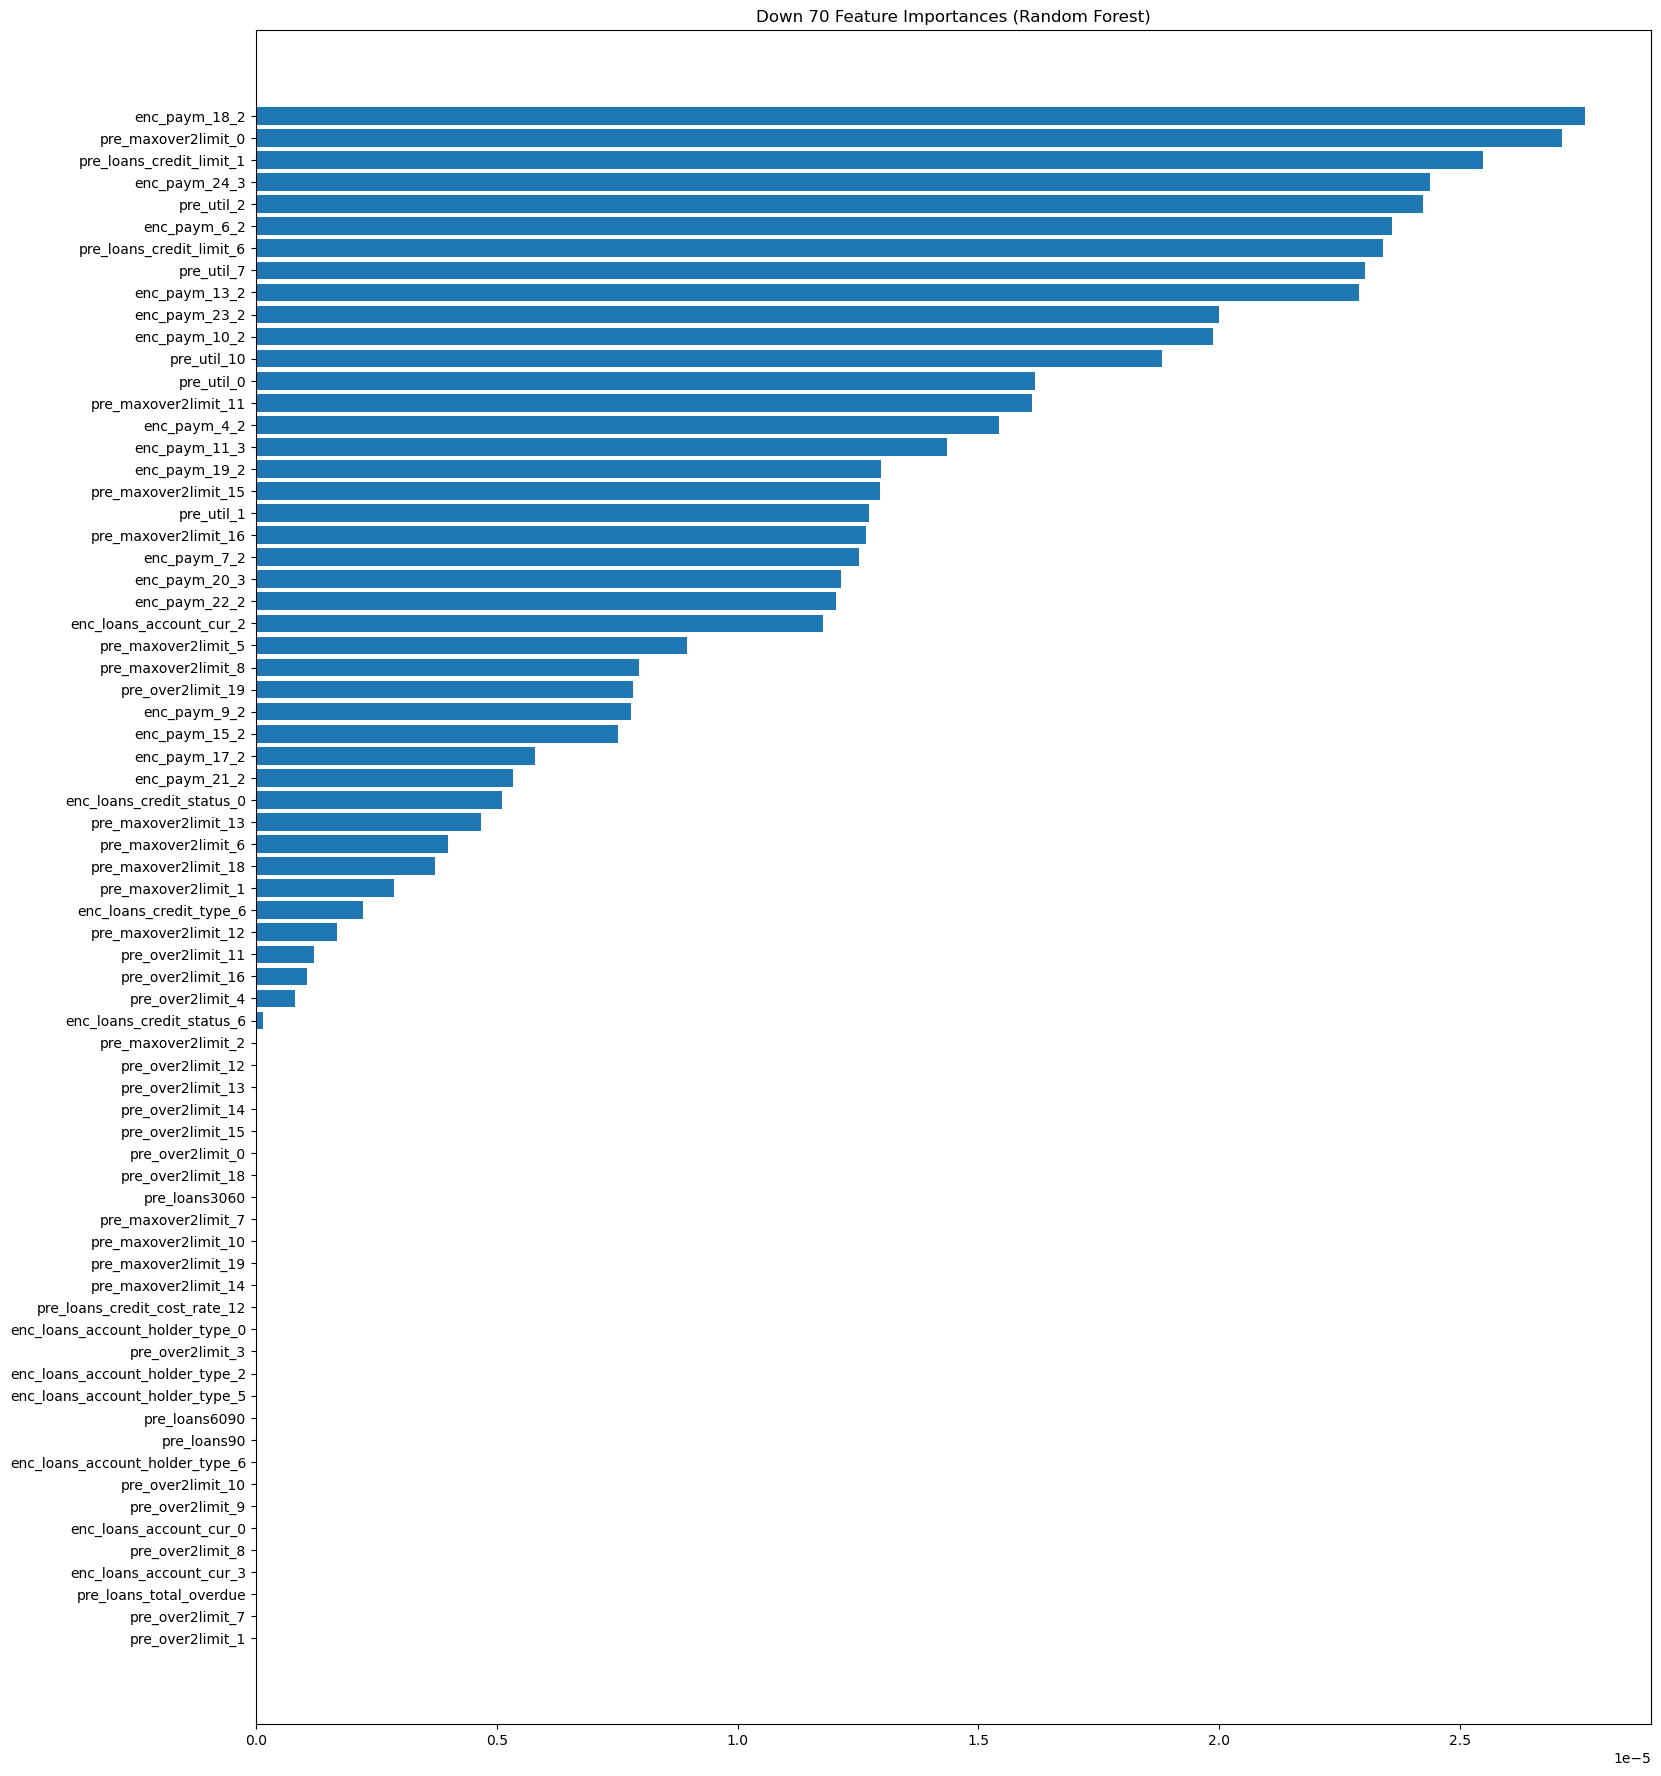

In [127]:
# Получение важностей признаков дерева
importances = model.feature_importances_
feature_names = X_train_transf.columns
# Создание DataFrame для удобства
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)
# Визуализация 
plt.figure(figsize=(18, 22))
plt.barh(feat_imp.tail(70)['feature'], feat_imp.tail(70)['importance'])
plt.gca().invert_yaxis()
plt.title('Down 70 Feature Importances (Random Forest)')
plt.savefig('D:/data/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. НЕЙРОСЕТЬ (NN)

In [101]:
# float32 все равно работает нейросеть, поэтому попробуем не умьньшать размерность
# уменьшаем память сокращая размерность данных
#X_train_transf = X_train_transf.astype({
#    col: 'float16' for col in X_train_transf.select_dtypes(include=['float32']).columns
#})

In [102]:
X_train_transf.info() # после преобразования 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400000 entries, 0 to 2399999
Columns: 249 entries, total_outstanding to fclose_flag
dtypes: float16(249)
memory usage: 1.1 GB


In [103]:
X_test_transf.info() # после преобразования 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Columns: 249 entries, total_outstanding to fclose_flag
dtypes: float32(249)
memory usage: 569.9 MB


In [107]:
# веса для NN записываем по другому для тензоров
pos_weight_v = (df_train[df_train[target] == 0].shape[0] / df_train[df_train[target] == 1].shape[0])
print(pos_weight_v)

27.184230922798694


In [109]:
# ВАЛИДАЦИЯ разбиваем исходный train на train + val
X_train_transf, X_val_transf, y_train, y_val = train_test_split(
    X_train_transf, y_train,
    test_size=0.2,
    random_state=RAND_SEED,
    stratify=y_train
)

In [110]:
print(f"Доступно RAM: {psutil.virtual_memory().available / (1024**3):.2f} GB")

Доступно RAM: 3.55 GB


In [113]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values.astype(np.float32))
        self.y = torch.tensor(y.values.astype(np.float32)).unsqueeze(1)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

# Подготовка данных
train_dataset = MyDataset(X_train_transf, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True) # ПАРАМЕТР !!!!!!! размеры батчей покорректируем

# Валидационные тензоры
X_val_tensor = torch.tensor(X_val_transf.values.astype(np.float32))
y_val_tensor = torch.tensor(y_val.values.astype(np.float32)).unsqueeze(1)

# Тестовые тензоры (опционально)
X_test_tensor = torch.tensor(X_test_transf.values.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32)).unsqueeze(1)

In [115]:
#ОСВОБОДИМ ПАМЯТЬ
# Больше не нужен — удаляем
del X_train_transf, X_test_transf
gc.collect()  # ← явно просим освободить память

0

In [117]:
# Модель
class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(249, 128) # ПАРАМЕТР !!!!!!! было 160 для 7492
        self.f1 = nn.ReLU()  # для тангенса стандартскалер нужен, т.е. около 0
        self.hidden2 = nn.Linear(128, 64)
        self.f2 = nn.ReLU()
        self.output = nn.Linear(64, 1)

    def forward(self, x):
        x = self.f1(self.hidden1(x))
        x = self.f2(self.hidden2(x))
        return self.output(x)

modelN = BinaryClassifier()

# Устройство и loss вроде доступны и gpu на ноуте
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelN.to(device)

# добавим pos_weight на одно устройство
pos_weight = torch.tensor([pos_weight_v], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.Adam(modelN.parameters(), lr=0.0001) # ПАРАМЕТР !!!!!!!  было 0.001 для 7492 потом здесь оптимизируем гиперпараметры

# Проверка данных
assert not torch.isnan(X_val_tensor).any(), "X_train содержит NaN!"
assert not torch.isnan(y_val_tensor).any(), "y_train содержит NaN!"
assert torch.all((y_val_tensor == 0) | (y_val_tensor == 1)), "y_train не в {0,1}!"
assert torch.isfinite(pos_weight).all(), "pos_weight некорректен!"

# Обучение с валидацией
num_epochs = 40 # ПАРАМЕТР !!!!!!!количество эпох потом подкорректируем
best_auc = 0.0
best_model_state = None

for epoch in range(num_epochs):
    # ---------- Тренировка ----------
    modelN.train()
    train_loss = 0.0
    for X_batch, y_batch in train_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = modelN(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_dataloader)

    # ---------- Валидация ----------
    modelN.eval()
    with torch.no_grad():
        X_val_tensor = X_val_tensor.to(device)
        y_val_tensor = y_val_tensor.to(device)
        
        val_logits = modelN(X_val_tensor)
        val_probs = torch.sigmoid(val_logits).cpu().numpy()
        val_labels = y_val_tensor.cpu().numpy().flatten()
        
        try:
            val_auc = roc_auc_score(val_labels, val_probs)
        except ValueError:
            # Если в val только один класс
            val_auc = 0.5  # или пропустить
        
        # Сохраняем лучшую модель по AUC
        if val_auc > best_auc:
            best_auc = val_auc
            best_model_state = copy.deepcopy(modelN.state_dict())

    # Вывод прогресса
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Val AUC: {val_auc:.4f}')

print(f'\nЛучший AUC на валидации: {best_auc:.4f}')

# Загружаем лучшую модель
modelN.load_state_dict(best_model_state)

# Финальная оценка на тесте
modelN.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    test_logits = modelN(X_test_tensor)
    test_probs = torch.sigmoid(test_logits).cpu().numpy()
    test_labels = y_test_tensor.numpy().flatten()
    
    test_auc = roc_auc_score(test_labels, test_probs)
    print(f'\nТестовый AUC: {test_auc:.4f}')

Epoch [10/40] Train Loss: 1.1331, Val AUC: 0.7505
Epoch [20/40] Train Loss: 1.1235, Val AUC: 0.7507
Epoch [30/40] Train Loss: 1.1153, Val AUC: 0.7462
Epoch [40/40] Train Loss: 1.1078, Val AUC: 0.7450

Лучший AUC на валидации: 0.7515

Тестовый AUC: 0.7532


In [ ]:
# История различных испытаний
#Epoch [10/50] Train Loss: 1.2137, Val AUC: 0.6951
#Epoch [20/50] Train Loss: 1.2155, Val AUC: 0.6939
#Epoch [30/50] Train Loss: 1.2155, Val AUC: 0.6948
#Epoch [40/50] Train Loss: 1.2173, Val AUC: 0.6922
#Epoch [50/50] Train Loss: 1.2153, Val AUC: 0.6930
#Лучший AUC на валидации: 0.6977
#Тестовый AUC: 0.6989

#Epoch [10/50] Train Loss: 1.1922, Val AUC: 0.7158
#Epoch [20/50] Train Loss: 1.1895, Val AUC: 0.7137
#Epoch [30/50] Train Loss: 1.1887, Val AUC: 0.7170
#Epoch [40/50] Train Loss: 1.1872, Val AUC: 0.7172
#Epoch [50/50] Train Loss: 1.1869, Val AUC: 0.7174
#Лучший AUC на валидации: 0.7182
#Тестовый AUC: 0.7225

#Epoch [10/50] Train Loss: 1.1532, Val AUC: 0.7450
#Epoch [20/50] Train Loss: 1.1568, Val AUC: 0.7447
#Epoch [30/50] Train Loss: 1.1664, Val AUC: 0.7372
#Epoch [40/50] Train Loss: 1.1601, Val AUC: 0.7396
#Epoch [50/50] Train Loss: 1.1636, Val AUC: 0.7357
#Лучший AUC на валидации: 0.7474
#Тестовый AUC: 0.7475

#Epoch [10/40] Train Loss: 1.1439, Val AUC: 0.7461
#Epoch [20/40] Train Loss: 1.1437, Val AUC: 0.7474
#Epoch [30/40] Train Loss: 1.1441, Val AUC: 0.7439
#Epoch [40/40] Train Loss: 1.1456, Val AUC: 0.7449
#Лучший AUC на валидации: 0.7480
#Тестовый AUC: 0.7492

### Настройка гиперпараметров с помощью OPTUNA

In [123]:
# для дальнейшего тюнинга используем optuna
#pip install optuna

In [113]:
#pip install shap matplotlib
import optuna
from sklearn.model_selection import ParameterGrid
import copy

In [115]:
# Определяем пространство параметров для Grid Search, сокращаем из-за нехватки памяти
param_grid = {
    'hidden_size1': [128, 160], #144, 
    'hidden_size2': [32, 64], #16, 24,
    'learning_rate': [0.0001], #0.0005], 
    'batch_size': [64, 32], #, 128],
    'dropout_rate': [0.0, 0.1] #, 0.2]
}
# Устройство и loss вроде доступны и gpu на ноуте КАК ВЫШЕ!!!!!!
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#modelN.to(device)

# добавим pos_weight на одно устройство
pos_weight = torch.tensor([pos_weight_v], dtype=torch.float32).to(device)

class TunableBinaryClassifier(nn.Module):
    def __init__(self, input_size=249, hidden_size1=160, hidden_size2=64, dropout_rate=0.0): #144 b 24
        super().__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.f1 = nn.ReLU()
        
        self.hidden2 = nn.Linear(hidden_size1, hidden_size2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.f2 = nn.ReLU()
        
        self.output = nn.Linear(hidden_size2, 1)

    def forward(self, x):
        x = self.f1(self.hidden1(x))
        x = self.dropout1(x)
        x = self.f2(self.hidden2(x))
        x = self.dropout2(x)
        return self.output(x)

def train_evaluate_model(params, num_epochs=100, patience=10):
    """Обучает и оценивает модель с заданными параметрами"""
    
    # Создаем модель
    model = TunableBinaryClassifier(
        hidden_size1=params['hidden_size1'],
        hidden_size2=params['hidden_size2'],
        dropout_rate=params['dropout_rate']
    ).to(device)
    
    # DataLoader с текущим batch_size
    train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    best_auc = 0.0
    best_model_state = None
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val_tensor.to(device))
            val_probs = torch.sigmoid(val_logits).cpu().numpy()
            val_auc = roc_auc_score(y_val_tensor.numpy().flatten(), val_probs)
        
        # Early stopping
        if val_auc > best_auc:
            best_auc = val_auc
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= patience:
            break
    
    return best_auc, best_model_state

# Запуск Grid Search
print("Starting Grid Search...")
best_grid_score = 0
best_grid_params = None
best_grid_model_state = None

for i, params in enumerate(ParameterGrid(param_grid)):
    print(f"Testing combination {i+1}/{len(ParameterGrid(param_grid))}: {params}")
    
    auc_score, model_state = train_evaluate_model(params)
    
    if auc_score > best_grid_score:
        best_grid_score = auc_score
        best_grid_params = params
        best_grid_model_state = model_state
    
    print(f"AUC: {auc_score:.4f}, Best: {best_grid_score:.4f}")

print(f"\nBest Grid Search params: {best_grid_params}")
print(f"Best Grid Search AUC: {best_grid_score:.4f}")

Starting Grid Search...
Testing combination 1/16: {'batch_size': 64, 'dropout_rate': 0.0, 'hidden_size1': 128, 'hidden_size2': 32, 'learning_rate': 0.0001}
AUC: 0.7508, Best: 0.7508
Testing combination 2/16: {'batch_size': 64, 'dropout_rate': 0.0, 'hidden_size1': 128, 'hidden_size2': 64, 'learning_rate': 0.0001}
AUC: 0.7515, Best: 0.7515
Testing combination 3/16: {'batch_size': 64, 'dropout_rate': 0.0, 'hidden_size1': 160, 'hidden_size2': 32, 'learning_rate': 0.0001}
AUC: 0.7515, Best: 0.7515
Testing combination 4/16: {'batch_size': 64, 'dropout_rate': 0.0, 'hidden_size1': 160, 'hidden_size2': 64, 'learning_rate': 0.0001}
AUC: 0.7515, Best: 0.7515
Testing combination 5/16: {'batch_size': 64, 'dropout_rate': 0.1, 'hidden_size1': 128, 'hidden_size2': 32, 'learning_rate': 0.0001}
AUC: 0.7512, Best: 0.7515
Testing combination 6/16: {'batch_size': 64, 'dropout_rate': 0.1, 'hidden_size1': 128, 'hidden_size2': 64, 'learning_rate': 0.0001}
AUC: 0.7511, Best: 0.7515
Testing combination 7/16: {'

### Оценка признаков по NN

In [120]:
# важность признаков нейронной сети
import shap
# Убедитесь, что модель в eval-режиме
modelN.eval()
# Базовый набор данных для DeepExplainer (обычно 50-200 случайных примеров)
background = X_val_tensor[:100].to(device)  # или X_val_tensor
# Создаём explainer
explainer = shap.DeepExplainer(modelN, background)
# Выбираем подмножество данных для объяснения (например, 50 первых из валидации)
to_explain = X_val_tensor[:50].to(device)
# Вычисляем SHAP-значения shap_values — это массив формы (50, 74) для бинарной классификации с одним выходом
shap_values = explainer.shap_values(to_explain)

In [130]:
print("Тип shap_values:", type(shap_values))
print("shap_values.shape:", shap_values.shape)
print("Количество признаков:", len(X_train_transf.columns))

Тип shap_values: <class 'numpy.ndarray'>
shap_values.shape: (50, 249)
Количество признаков: 249


In [142]:
# что не учитываем
new_cols = ['total_outstanding','weighted_late_score'] #'total_credit_limit', 'total_late_payments', 'total_util_ratio',
new_in_cols = ['avg_payment_score','recent_payment_score','payment_trend','is_perfect','num_credit_types','loans_per_time'] #,'is_high_risk'] #,'util_x_rn','is_high_risk']
new_age_cols = ['loan_age'] #, 'loan_age_ratio']

In [142]:
# МОЖНО УДАЛЯТЬ по NN!!!!!!!!!!!!!!!!!!
del2new_cols = ['total_util_ratio'] 
del2new_in_cols = ['is_high_risk'] #,'util_x_rn','is_high_risk']
del2new_age_cols = ['loan_age_ratio']

In [99]:
# МОЖНО УДАЛЯТЬ по лесу!!!!!!!!!!!!!!!!!!
delnew_cols = ['total_util_ratio'] #'total_credit_limit', 'total_late_payments',
delnew_in_cols = ['payment_trend','num_credit_types'] #,'util_x_rn','is_high_risk']
delnew_age_cols = ['loan_age_ratio']

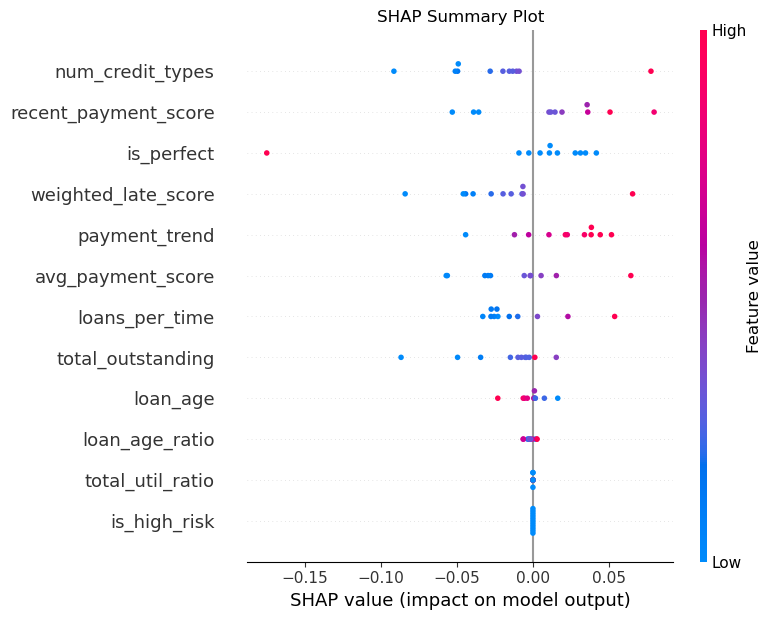

In [156]:
# ТОЛЬКО ВЫБРАННЫЕ ФИЧИ
# Убедимся, что всё на CPU
modelN_cpu = modelN.cpu()
modelN_cpu.eval()
select_feats = new_cols + new_in_cols + new_age_cols
# Получаем индексы нужных фичей
selected_indices = [X_train_transf.columns.get_loc(col) for col in select_feats]

# Фильтруем данные
shap_values_filtered = shap_values[:, selected_indices]
features_filtered = to_explain_cpu.numpy()[:, selected_indices]

# Теперь вызываем summary_plot
shap.summary_plot(
    shap_values_filtered,
    features_filtered,
    feature_names=select_feats,
    plot_type="dot",
    show=False
)
plt.title("SHAP Summary Plot")
plt.tight_layout()
plt.savefig('D:/data/shap_summary_new1.png', dpi=300, bbox_inches='tight')
plt.show()

### 📊 ОСНОВНЫЕ ЭЛЕМЕНТЫ ГРАФИКА

### 1. **По вертикали: названия фичей**
Отсортированы по важности (сверху — самые влиятельные).
### 2. **По горизонтали: SHAP value (влияние на выход модели)**
- Положительное значение → увеличивает предсказание модели.
- Отрицательное значение → уменьшает предсказание.
- Ноль → не влияет.
> Пример: если модель предсказывает вероятность дефолта, то положительный SHAP value = признак повышает риск дефолта.
### 3. **Цвет точек: значение самой фичи (Feature value)**
- 🔵 **Синий** — низкое значение фичи.
- 🔴 **Красный/розовый** — высокое значение фичи.
- Цветовая шкала справа: от "Low" до "High".
> Это позволяет понять: *как именно значение фичи влияет на SHAP value*.
## 🔍 КАК ЧИТАТЬ ГРАФИК?
Для каждой строки (фичи) смотрим:
- **Где сконцентрированы точки?** → это показывает, как сильно фича влияет.
- **Какой цвет у точек слева/справа?** → показывает, какие значения фичи приводят к положительному или отрицательному эффекту.
## 🧠 ПРИМЕРЫ ИНТЕРПРЕТАЦИИ
### ✅ `num_credit_types` (число типов кредитов)
- Точки в основном **слева** (отрицательный SHAP) → большинство значений снижают риск.
- Но есть **красные точки справа** → когда число типов кредитов **высокое**, это **увеличивает риск** (SHAP > 0).
→ **Вывод**: чем больше типов кредитов у клиента — тем выше его риск (но только при больших значениях).
### ✅ `recent_payment_score` (оценка последнего платежа)
- Синие точки слева → низкие значения этой фичи (плохие платежи) → **отрицательный SHAP** → снижают риск? 🤔
- Красные точки справа → высокие значения (хорошие платежи) → **положительный SHAP** → **повышают риск?**
⚠️ Это **противоречит интуиции**! Обычно хороший платёж должен снижать риск.
👉 Возможные причины:
- Модель может предсказывать **не риск дефолта, а что-то другое** (например, вероятность одобрения кредита).
- Или в данных есть **обратная зависимость** (например, люди с хорошими платежами берут больше кредитов → и риск растёт).
- Или **фича закодирована наоборот** (чем выше score — тем хуже).
📌 **Важно:** всегда проверяйте, **что предсказывает ваша модель** (риск? одобрение? доход?) и **как закодированы фичи**.
### ✅ `is_perfect` (бинарный признак: идеальный клиент?)
- Точки распределены по обе стороны.
- Синие точки слева → `is_perfect=0` → отрицательный SHAP → снижает риск. синие точки справа!!!!!!!!
- Красные точки справа → `is_perfect=1` → положительный SHAP → **повышает риск?** красная точка слева!!!!!
НЕ ВЕРНО ИНТЕРПРИТИРОВАЛ. Красные не увеличивают риск и они слева. Опять же — странно. Если `is_perfect=1` — значит, клиент идеален, но SHAP говорит, что это **увеличивает риск**.
→ Возможно, `is_perfect` — это **обратный признак** (например, 1 = есть проблемы), или модель ошибается, или данные содержат шум.
### ✅ `weighted_late_score` (взвешенный балл просрочек)
- Точки слева — синие → низкие значения → отрицательный SHAP → снижают риск.
- Точки справа — красные → высокие значения → положительный SHAP → **увеличивают риск**.
✅ Логично: чем выше просрочка — тем выше риск.
### ✅ `payment_trend` (динамика платежей)
- Есть как положительные, так и отрицательные SHAP.
- Красные точки справа → высокие значения → положительный SHAP → **увеличивают риск**.
- Синие точки слева → низкие значения → отрицательный SHAP → **снижают риск**.
→ Зависит от того, что означает "высокий тренд". Если это "ухудшение платежей", то логично.
### ✅ `is_high_risk` (бинарный признак: высокий риск?)
- Почти все точки вокруг нуля → **очень слабое влияние**.
- Несколько синих точек внизу — отрицательный SHAP → `is_high_risk=0` снижает риск? 😕
- Красные точки — `is_high_risk=1` → положительный SHAP → **увеличивает риск**.
✅ Логично, если `is_high_risk=1` действительно означает высокий риск.
## 🎯 ОБЩИЙ ВЫВОД ПО ГРАФИКУ
1. **Наиболее важные фичи** (по ширине и разбросу):
   - `num_credit_types`
   - `recent_payment_score`
   - `is_perfect`
   - `weighted_late_score`
2. **Фичи, которые однозначно увеличивают риск** при высоких значениях:
   - `weighted_late_score`
   - `payment_trend` (если высокий = плохой)
   - `is_high_risk`
3. **Фичи, где связь противоречит интуиции**:
   - `recent_payment_score`
   - `is_perfect`
     
→ Проверить, **как закодированы эти фичи**, и **что именно предсказывает модель**. Возможно, нужно переформулировать задачу или перекодировать признаки.
- Если **нелогичные связи** — проверить:
  - Данные (нет ли ошибок в кодировке?)
  - Целевую переменную (что именно предсказывает модель?)
  - Модель (не переобучилась ли она?)
- Использовать `shap.summary_plot(..., plot_type="bar")` для быстрого просмотра **важности фичей**.
- Для глубокого анализа — использовать `shap.dependence_plot()` для одной фичи, чтобы увидеть её влияние в зависимости от других фич.

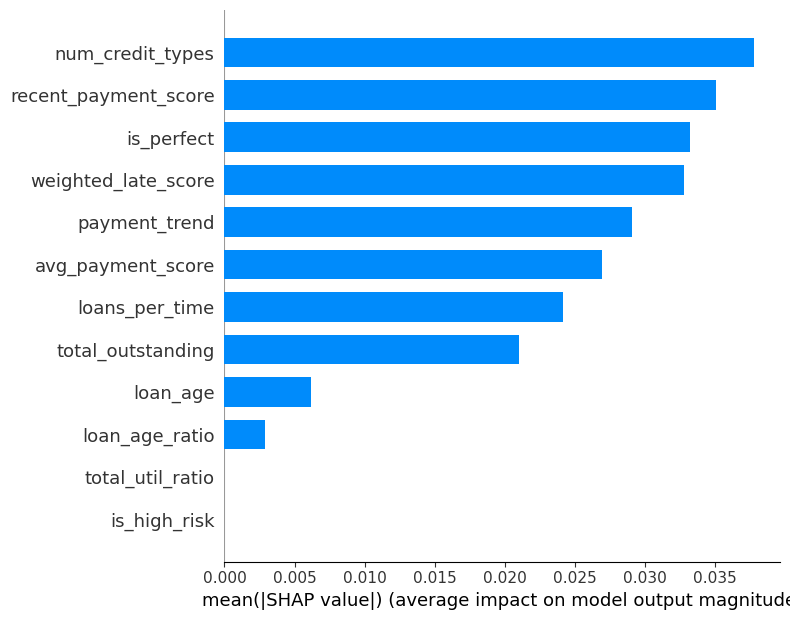

In [160]:
shap.summary_plot(shap_values_filtered, X_train_transf[select_feats], plot_type="bar", max_display=50, show=False)
fig = plt.gcf()
fig.savefig('D:/data/shap_summary_new.png', dpi=300, bbox_inches='tight')

Исправленная форма: (50, 249)


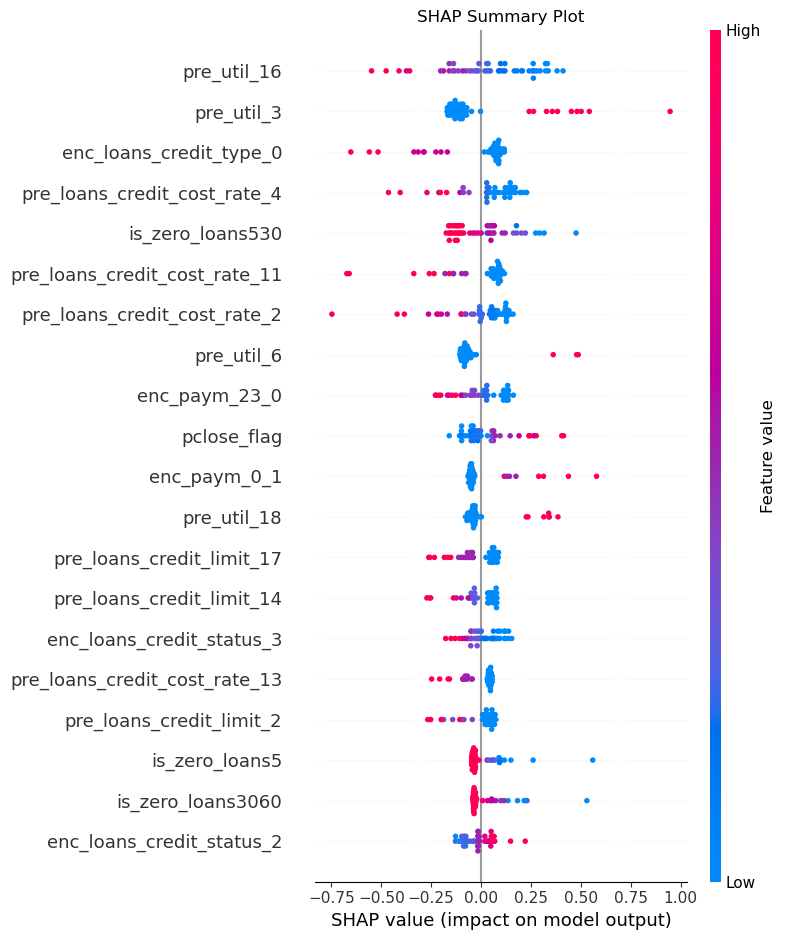

In [134]:
# Убедимся, что всё на CPU
modelN_cpu = modelN.cpu()
modelN_cpu.eval()
background_cpu = X_val_tensor[:100].cpu()
to_explain_cpu = X_val_tensor[:50].cpu()

# SHAP
explainer = shap.DeepExplainer(modelN_cpu, background_cpu)
shap_values = explainer.shap_values(to_explain_cpu)

# Исправляем форму: (50, 249, 1) → (50, 249)
if shap_values.ndim == 3 and shap_values.shape[-1] == 1:
    shap_values = shap_values.squeeze(-1)

# Проверка
print("Исправленная форма:", shap_values.shape)  # Должно быть (50, 249)

# График
shap.summary_plot(
    shap_values,
    to_explain_cpu.numpy(),
    feature_names=X_train_transf.columns,
    plot_type="dot",
    show=False
)
plt.title("SHAP Summary Plot")
plt.tight_layout()
plt.savefig('D:/data/shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

### Проведем оценку признаков
Наиболее важным признаком является is_zero_util — отсутствие текущей задолженности снижает вероятность дефолта. Признаки is_zero_loans530 и is_zero_loans5 также показывают, что отсутствие просрочек снижает риск. Модель различает типы кредитов (enc_loans_credit_type_3, _4) и историю платежей (enc_paym_...). 
Ось Y: признаки, отсортированные по важности (сверху — самые важные).
Ось X: SHAP-значение → влияние на логит модели (до сигмоиды).
Положительное значение (право) → увеличивает вероятность класса 1 (например, «дефолт»).
Отрицательное значение (лево) → снижает вероятность класса 1.
Цвет точки:
Красный/розовый = высокое значение признака.
Синий/фиолетовый = низкое значение признака
is_zero_util — ТОП-1 признак
Что означает? Флаг: отношение оставшейся невыплаченной суммы к лимиту = 0 → нет задолженности.
График: большинство точек слева (отрицательный SHAP) и синие → значит, если is_zero_util=1 (нет долга) → модель снижает риск.
Логика: если человек не имеет задолженности — он надёжен → модель правильно работает.
✅ Вывод: очень логичный и важный признак
 is_zero_loans530 — второй по важности
Что означает? Флаг: нет просрочек от 5 до 30 дней.
График: синие точки слева → если нет просрочек → SHAP < 0 → снижение риска.
Красные точки справа → если есть просрочки → SHAP > 0 → повышение риска.
✅ Вывод: модель корректно учитывает наличие/отсутствие просрочек
enc_loans_credit_type_3, enc_loans_credit_type_4 — закодированные типы кредита
Это категориальные признаки, закодированные OneHotEncoder.
Видно, что для некоторых значений (например, credit_type_3) есть красные точки справа → высокий SHAP → повышают риск.
Для других — синие точки слева → снижают риск.
✅ Вывод: модель различает типы кредитов по риску — например, кредит типа 3 может быть более рискованным.
pclose_flag — флаг: плановое количество дней до закрытия не определено
График: разбросано, но есть красные точки справа → если флаг активен → SHAP > 0 → повышает риск.
Возможно, неопределённый срок закрытия — сигнал риска.
✅ Вывод: логично — если кредит "не имеет конца", это может быть признаком проблем
is_zero_loans5, is_zero_loans3060, is_zero_over2limit — флаги без просрочек и без превышения лимита
Все они показывают отрицательный SHAP при синих точках → если флаг = 1 → риск ниже.
Логично: отсутствие просрочек и превышения лимита — признак надёжности.
✅ Вывод: модель использует эти флаги как признаки низкого риска.
7. pre_loans_credit_limit — кредитный лимит
График: разбросано, но есть красные точки справа → высокий лимит → SHAP > 0 → выше риск.
Возможно, высокий лимит связан с более рискованными клиентами (или наоборот — с более надёжными, но модель решила иначе).
⚠️ Проверьте бизнес-логику: в вашей задаче высокий лимит — это хорошо или плохо
8. enc_paym_11_4, enc_paym_7_3, enc_paym_2_3 — статусы платежей
Эти признаки кодируют историю платежей.
Видно, что для разных значений есть разное влияние:
Некоторые значения (например, paym_11_4) дают положительный SHAP → повышают риск.
Другие — отрицательный SHAP → снижают риск.
✅ Вывод: модель умеет различать "хорошие" и "плохие" истории платежей

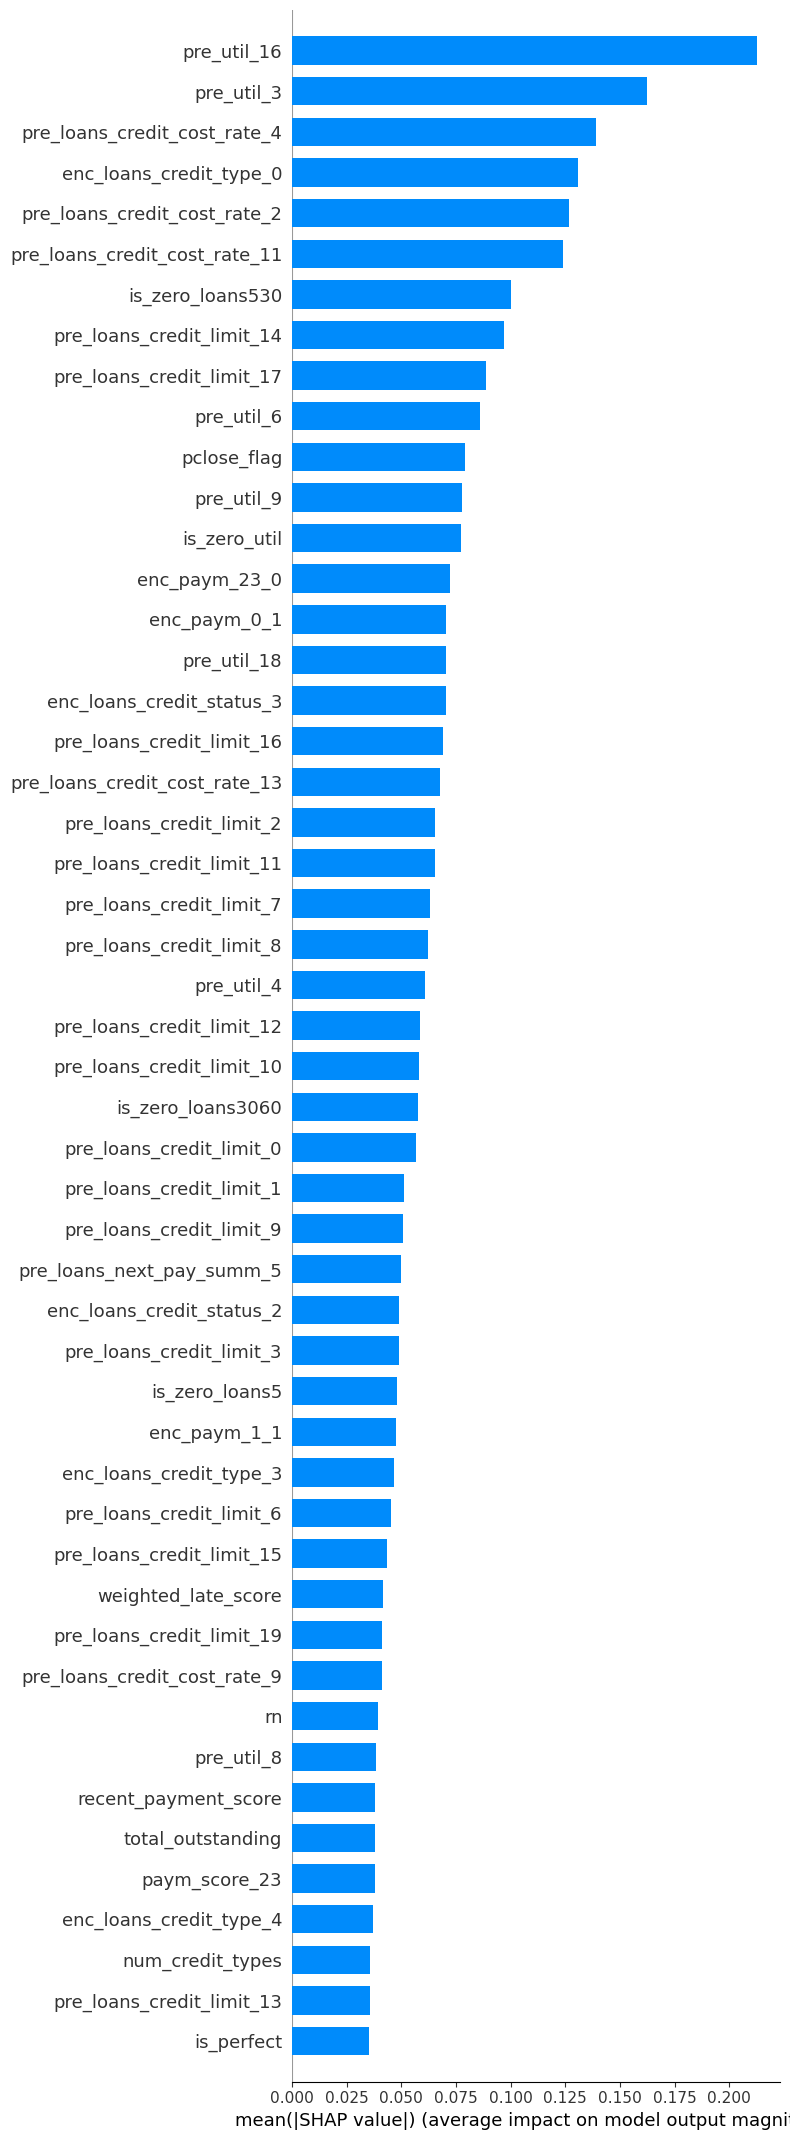

In [151]:
shap.summary_plot(shap_values, X_train_transf, plot_type="bar", max_display=50)

## 8.Записываем в pickle

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import pickle

In [ ]:
### 1. **FeatureGeneratorBeforeAgg** — трансформер для создания фичей до агрегации
def fast_mode(series):
    modes = series.mode()
    return modes.iloc[0] if not modes.empty else np.nan
class FeatureGeneratorBeforeAgg(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
# ВРЕМЕННЫЕ: время жизни кредита и доля времени
        X['loan_age'] = X['pre_fterm'] - X['pre_since_opened'] # сколько дней осталось до закрытия
# ФИНАНСОВЫЕ: общая нагрузка по кредитам
        X['total_outstanding'] = X.groupby('id')['pre_loans_outstanding'].transform('sum')
# ПРОСРОЧКИ: добавляем веса
        X['weighted_late_score'] = (
            X['pre_loans5'] * 1 +
            X['pre_loans530'] * 2 +
            X['pre_loans3060'] * 3 +
            X['pre_loans6090'] * 4 +
            X['pre_loans90'] * 5
        )
        return X

In [ ]:
### 2. **Aggregator** — трансформер для агрегации по `id`
class Aggregator(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        # Выполняем OHE для категориальных фичей (если нужно в трансформере)
        # Предположим, что все фичи, кроме id, уже подготовлены к агрегации
    # ГЕНЕРИМ НОВЫЕ ФИЧИ 
        df = generate_features(df)
# новые фичи 
        new_cols = ['total_outstanding'] #,'total_util_ratio'] #'total_credit_limit', 'total_late_payments',
        new_weight_cols = ['weighted_late_score']
        new_age_cols = ['loan_age'] #, 'loan_age_ratio']
# и отдельная группировка по rn как максимальному количеству взятых кредитных продуктов одним клиентом
        max_cols = ['rn']  
# временные фичи  
        date_cols = ['pre_pterm', 'pre_fterm', 'pre_till_pclose', 'pre_till_fclose', 'pre_since_opened', 'pre_since_confirmed']
# КАТЕГОРИАЛЬНЫЕ фичи, из которых после OHE-преобразования получим ohe_cat_cols   
        abs_sum_cols1 = ['pre_loans_credit_limit', 'pre_loans_next_pay_summ', 'pre_loans_credit_cost_rate'] # абсолютные суммы
        ratio_cols = ['pre_util', 'pre_over2limit', 'pre_maxover2limit']  # полученные отношения от абсолютных сумм median_cols1
        cat_cols = ['enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9',
                     'enc_paym_10', 'enc_paym_11', 'enc_paym_12', 'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16', 'enc_paym_17', 'enc_paym_18',
                     'enc_paym_19', 'enc_paym_20', 'enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24',
                     'enc_loans_account_holder_type', 'enc_loans_credit_status',
                     'enc_loans_credit_type', 'enc_loans_account_cur'] #по сути категориальные фичи (до бинаризации)
# НЕ КАТЕГОРИАЛЬНЫЕ, но разделены по квантилям (в корреляции и можно использовать вместе с категориальными)
        num_overdues = ['pre_loans5', 'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90'] # число просрочек median_cols2
        abs_sum_cols2 = ['pre_loans_outstanding', 'pre_loans_total_overdue', 'pre_loans_max_overdue_sum'] # суммы по кредитам - МОЖНО в одну группу с абсолютными
# ФЛАГИ (ПРОПУСКАЕМ эти фичи при обработке)     
        flag_cols = ['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90',
                     'is_zero_util', 'is_zero_over2limit', 'is_zero_maxover2limit'] # флаги по просрочкам и флаги по отношениям  
        date_flag_cols = ['pclose_flag', 'fclose_flag'] # флаги по датам

        ohe_cols = cat_cols + ratio_cols + abs_sum_cols1 # колонки, которые отправим в OHE

# сократим объем памяти, упростив типы данных, id больше int8
        for col in df.select_dtypes(include=['int64']).columns:
            df[col] = pd.to_numeric(df[col], downcast='integer') 
        for col in df.select_dtypes(include=['float64']).columns:
            df[col] = pd.to_numeric(df[col], downcast='float')

# Применяем get_dummies (аналог OneHotEncoder) для категориальных!!!!!!!!!!!!!!!!
        df = pd.get_dummies(df, columns=ohe_cols, prefix=ohe_cols)
        ohe_cat_cols = [col for col in df.columns if col.startswith(tuple([f"{c}_" for c in ohe_cols]))] # провели КАТЕГОРИЗАЦИЮ

 # Определяем агрегационные правила
        agg_rules = {}
 # Определяем агрегационные правила
        for col in max_cols:
            agg_rules[col] = 'max'
        for col in ohe_cat_cols:
            agg_rules[col] = 'sum'
        for col in num_overdues:
            agg_rules[col] = fast_mode
        for col in abs_sum_cols2:
            agg_rules[col] = fast_mode
        for col in flag_cols:
            agg_rules[col] = 'mean'
        for col in date_flag_cols:
            agg_rules[col] = 'mean'
        for col in new_cols:
            agg_rules[col] = 'max'
        for col in new_weight_cols:
            agg_rules[col] = 'sum'
        for col in new_age_cols:
            agg_rules[col] = 'median'
        for col in date_cols:
            agg_rules[col] = 'median'

 # Агрегируем
        df_agg = X.groupby('id').agg(agg_rules).reset_index()

 # Понижаем размерность
        for col in df_agg.select_dtypes(include=['int64']).columns:
            df_agg[col] = df_agg[col].astype('int16')
        for col in df_agg.select_dtypes(include=['float64']).columns:
            df_agg[col] = df_agg[col].astype('float32')

        return df_agg

In [ ]:
### 3. **FeatureCreatorAfterAgg** — трансформер для создания фичей после агрегации
class FeatureCreatorAfterAgg(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
# Отличный клиент
        X['is_perfect'] = (
            (X['is_zero_loans5'] == 1) &
            (X['is_zero_loans530'] == 1) &
            (X['is_zero_loans3060'] == 1) &
            (X['is_zero_loans6090'] == 1) &
            (X['is_zero_loans90'] == 1) &
            (X['is_zero_util'] == 1)
        ).astype('int8')
# Оценка платежей
        for month in range(0, 25):  # у нас до 24
            cols = [f'enc_paym_{month}_{i}' for i in range(5) if f'enc_paym_{month}_{i}' in X.columns]
            if cols:
                weights = list(range(len(cols)))  # [0,1,2,3,4]
                X[f'paym_score_{month}'] = sum(X[col] * w for col, w in zip(cols, weights))
# Общая оценка платежей
        paym_cols = [f'paym_score_{m}' for m in range(25) if f'paym_score_{m}' in X.columns]
        X['avg_payment_score'] = X[paym_cols].mean(axis=1)
        X['recent_payment_score'] = X[['paym_score_0', 'paym_score_1', 'paym_score_2']].mean(axis=1)
        X['payment_trend'] = X['paym_score_0'] - X['paym_score_12']  # ухудшение за год
        credit_type_cols = [col for col in X.columns if col.startswith('enc_loans_credit_type_')]
        X['num_credit_types'] = X[credit_type_cols].sum(axis=1)
# Интенсивность кредитования
        X['loans_per_time'] = X['rn'] / (X['pre_since_opened'] + 1)  # кредитов на день истории

        # ВОЗМОЖНО удаляем ненужные колонки, которые коррелированы или не несут информацию
        #col_m1 = [col for col in X.columns if col.startswith("pre_over2limit_")]
        #col_m2 = [col for col in X.columns if col.startswith('pre_maxover2limit_')]
        #df=X.drop(columns=col_m1+col_m2, axis=1)

        
        return X

In [ ]:
# СТАРТ
# предварительно выделим для теста!!!!!
# 1. Читаем данные
df_transactions = pd.read_parquet('D:/TEST/transactions.pq')  # df чистый записать до агрегации - ПРОСТО ЧТЕНИЕ!!!!!!
df_transactions = df_transactions.drop(columns=['flag'], errors='ignore') # уберем для чистоты таргет, т.к. мержа не должно быть
df_targets = pd.read_csv('D:/TEST/train_target.csv')  # Дили .parquet; колонки: ['id', 'target']

# 2. Проверяем, что id совпадают по типу
df_transactions['id'] = df_transactions['id'].astype(int)
df_targets['id'] = df_targets['id'].astype(int)

# 3. Применяем пайплайн к транзакционным данным
# Разделяем пайплайн: делаем fit_transform только до предобработки
feature_pipeline = Pipeline([
    ('generate_features_before_agg', FeatureGeneratorBeforeAgg()),
    ('aggregate', Aggregator()),
    ('create_features_after_agg', FeatureCreatorAfterAgg()),
])
# Преобразуем транзакции в агрегированный датафрейм
X_agg = feature_pipeline.fit_transform(df_transactions)  # shape: (n_clients, n_features)

# 4. Теперь объединяем с target по id
X_final = X_agg.merge(df_targets[['id', 'target']], on='id', how='left')

# Проверяем, что все target не NaN
if X_final['target'].isnull().any():
    print("⚠️ Внимание: некоторые клиенты не имеют target!")
    X_final = X_final.dropna(subset=['target'])

# 5. Выделяем X и y для обучения
X_train = X_final.drop(columns=['id', 'target'])
y_train = X_final['target']

# 6. Препроцессор. Нужно проверить на inf,
ohe_cat_cols = [col for col in df.columns if col.startswith(tuple([f"{c}_" for c in ohe_cols]))]
# ohe_cols = cat_cols + ratio_cols + abs_sum_cols1
ct = ColumnTransformer(
    transformers=[
        # Числовые признаки (без ohe_cols!)
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', MinMaxScaler32()) # попробуем со склалером на 32, т.к. нейросеть по 32 работает, но можно уменьшить и до 16
        ]), new_cols + new_age_cols + max_cols + date_cols + new_in_cols + num_overdues + abs_sum_cols2 + new_pay_cols + ohe_cat_cols),
        
        # Флаги и OHE-признаки — просто передаём как есть
        ('passthrough', 'passthrough', flag_cols + date_flag_cols)
    ],
    remainder='drop'
)

# 7. Теперь можно обучать модель 
best_params = {'colsample_bytree': 0.8916028672163949, 'gamma': 0.38563517334297287, 'learning_rate': 0.03221339552022711,
               'max_depth': 5, 'min_child_weight': 9, 'reg_alpha': 2.4646297296191846, 'reg_lambda': 2.846065804843518,
               'subsample': 0.7797802696552814, 'n_estimators': 3000}
pipeline_full = Pipeline([
    ('preprocessor', ct),
    ('classifier', XGBClassifier(
        **best_params,
        n_estimators=3000,
        random_state=RAND_SEED,
        eval_metric='auc',
        use_label_encoder=False,
        tree_method='hist',
        scale_pos_weight=class_weights[1],
        verbosity=0
    ))
])

pipeline_full.fit(X_train, y_train)

In [ ]:
# После обучения
with open('feature_pipeline.pkl', 'wb') as f:
    pickle.dump(feature_pipeline, f)
with open('full_model.pkl', 'wb') as f:
    pickle.dump(pipeline_full, f)

In [ ]:
# Загружаем feature_pipeline
with open('feature_pipeline.pkl', 'rb') as f:
    feature_pipeline = pickle.load(f)
# Загружаем full_model
with open('full_model.pkl', 'rb') as f:
    full_model = pickle.load(f)

# Применяем к новым данным
df_new = pd.read_parquet('D:/TEST/transactions.pq')#файл для теста из чистого файла НО С ТАРГЕТОМ
# вырезать слайс или он заранее меньше......

df_new_transactions = df_new.drop(columns=['id','flag'], errors='ignore')
y_test_orig = df_new['flag']
X_new_agg = feature_pipeline.transform(df_new_transactions)
X_new = X_new_agg.drop(columns=['id'], errors='ignore')
preds = full_model.predict_proba(X_new)[:, 1]
final_auc = roc_auc_score(y_test_orig, preds)

In [ ]:
# попробовать предсказание на тестовых данных еще раз НЕ ТРАНСФОРМИРОВАННЫХ X_test_transf, А ИСХОДНЫХ ПРИ ЧТЕНИИ
# разделить их для этого и выделить тестовую без новых колонок-фичей

y_pred_final = loaded_pipeline.predict(X_test_orig)
y_pred_proba_final = loaded_pipeline.predict_proba(X_test_orig)[:, 1]

final_auc = roc_auc_score(y_test_orig, y_pred_proba_final)
final_accuracy = (y_pred_final == y_test_orig).mean()

In [ ]:
# Шаг 1: агрегируем X
X_agg = feature_pipeline.fit_transform(df_transactions)
# Шаг 2: объединяем с target
Xy = X_agg.merge(df_targets[['id', 'target']], on='id', how='left').dropna(subset=['target'])
# Шаг 3: выделяем X и y
X_train = Xy.drop(columns=['id', 'target'])
y_train = Xy['target']
# Шаг 4: обучаем full_pipeline
full_pipeline.fit(X_train, y_train)

## ⚠️ Важно:
- **`X` для пайплайна** должен быть **транзакционным датафреймом**, с `id`, который будет агрегироваться.
- **`y`** должен быть **таблицей с `id` и `target`** — т.е. **уже агрегированной** или **объединённой** с агрегированным X по `id`.
- После агрегации в пайплайне, `X` становится **по клиентам**, и `y` должен соответствовать по `id`.
## 🧠 Подсказка:
Если вы хотите, чтобы **`y`** тоже агррегировалась по `id`, то можно:
- В `Aggregator` добавить `y` как столбец перед `groupby`, и агрегировать его как `max`, `mean`, `first`, в зависимости от задачи.
- Или **вручную** объединить `y` с агрегированным `X` по `id`.
## ✅ Итог:
Вы можете **включить все этапы** — создание фичей до/после агрегации, саму агрегацию — в **один пайплайн**, если обернёте каждый этап в `TransformerMixin`.
Это позволяет:
- Упростить код
- Обеспечить воспроизводимость
- Упростить кросс-валидацию (если бы она была по клиентам)

In [ ]:
### 4. **Пайплайн с агрегацией и созданием фичей внутри**
#pipeline = Pipeline([
#    ('generate_features_before_agg', FeatureGeneratorBeforeAgg()),
#    ('aggregate', Aggregator()),
#    ('create_features_after_agg', FeatureCreatorAfterAgg()),
#    ('preprocessor', ct),  # ваш ColumnTransformer
#    ('classifier', XGBClassifier(
#        random_state=42,
#        eval_metric='auc',
#        scale_pos_weight=class_weights[1],
#        learning_rate=0.01,
#        max_depth=6,
#        n_estimators=700,
#        subsample=0.8,
#        colsample_bytree=0.8,
#        min_child_weight=5,
#        gamma=0.1,
#        reg_lambda=2,
#        use_label_encoder=False,
#        verbosity=0
#    ))
#])

In [ ]:
# более надежно для продакшна
import joblib
joblib.dump(pipeline, 'pipeline.joblib')

In [ ]:
model_info = {
    'pipeline': pipeline,
    'feature_names': feature_names,
    'model_version': '1.0',
    'training_date': '2024-01-01'
}

joblib.dump(model_info, 'model_package.joblib')

In [ ]:
#best_model.fit(x, y)
# сохраняем в pickle best_model
#filename = 'model_xgb.pickle'
#with open(filename, 'wb') as file:
#  pickle.dump(best_model, file)
# проверим как читается
#with open(filename, 'rb') as file:
#  model_from_pickle = pickle.load(file)
# model_from_pickle

In [ ]:
# ОБЪЯСНЕНИЕ:     Создаем трансформер
feature_creator = FeatureCreator()
# fit - "обучаем" (ничего не делаем)
feature_creator.fit(X_train)
# transform - применяем преобразования
X_train_with_new_features = feature_creator.transform(X_train)
# Или одной операцией
X_train_with_new_features = feature_creator.fit_transform(X_train)

In [ ]:
pipeline = Pipeline([
    ('feature_creator', FeatureCreator()),  # Этот шаг
    ('preprocessor', ct),
    ('classifier', XGBClassifier())
])

# При pipeline.fit():
# 1. feature_creator.fit(X_train) → возвращает self
# 2. feature_creator.transform(X_train) → данные с новыми фичами
# 3. preprocessor.fit(данные_с_фичами)
# 4. preprocessor.transform(данные_с_фичами)
# 5. classifier.fit(преобразованные_данные, y_train)

# При pipeline.predict(new_data):
# 1. feature_creator.transform(new_data) → автоматически, без fit!
# 2. preprocessor.transform(данные_с_фичами)
# 3. classifier.predict(преобразованные_данные)

In [ ]:
# ИЛИ ВТОРОЙ ВАРИАНТ!!!!!!!  Добавьте создание фич прямо в существующий ColumnTransformer
class FeatureCreator(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass 
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        # Ваши новые фичи
        X['is_perfect'] = (
            (X['is_zero_loans5'] == 1) &
            (X['is_zero_loans530'] == 1) &
            (X['is_zero_loans3060'] == 1) &
            (X['is_zero_loans6090'] == 1) &
            (X['is_zero_loans90'] == 1) &
            (X['is_zero_util'] == 1)
        ).astype('int8')
        X['is_high_risk'] = (
            (X['is_zero_loans90'] == 0) | 
            ((X['is_zero_util'] == 0) & 
             (X['is_zero_over2limit'] == 0) & 
             (X['is_zero_maxover2limit'] == 0))
        ).astype('int8')
        return X

ct = ColumnTransformer(
    transformers=[
        # Создание новых фич
        ('feature_creator', FeatureCreator(), ['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 
                                              'is_zero_loans6090', 'is_zero_loans90', 'is_zero_util',
                                              'is_zero_over2limit', 'is_zero_maxover2limit']),
        # Остальные трансформации
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', MinMaxScaler16())
        ]), new_cols + new_age_cols + max_cols + date_cols + new_in_cols + num_overdues + abs_sum_cols2 + new_pay_cols + ohe_cat_cols),        
        ('passthrough', 'passthrough', flag_cols + date_flag_cols + ['is_perfect', 'is_high_risk'])
    ],
    remainder='drop'
)

## Возможные дальнейшие улучшения по доп параметрам, фичам, моделям и пр.

In [ ]:
# Пример Focal Loss для бинарной классификации
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

In [ ]:
# Пример: подбор порога под максимум F1
from sklearn.metrics import f1_score

probs = torch.sigmoid(model(X_val)).cpu().numpy()
y_true = y_val.cpu().numpy()

best_thresh, best_f1 = 0.5, 0
for thr in np.arange(0.1, 0.9, 0.01):
    preds = (probs > thr).astype(int)
    f1 = f1_score(y_true, preds)
    if f1 > best_f1:
        best_f1, best_thresh = f1, thr

print(f"Лучший порог: {best_thresh:.2f}, F1: {best_f1:.4f}")

In [ ]:
# downsampling!!!!!!!!!!!!!!
#from imblearn.under_sampling import RandomUnderSampler
#X = df.drop('target', axis=1)
#y = df['target']
# Но применять ТОЛЬКО к train!
#rus = RandomUnderSampler(random_state=42)
#X_res, y_res = rus.fit_resample(X_train, y_train)

In [ ]:
#Генерация фич ДРУГИМ СПОСОБОМ
#import featuretools as ft
# Создание EntitySet
#es = ft.EntitySet(id='data_set')
# Добавление исходного DataFrame в EntitySet
#es = es.entity_from_dataframe(entity_id='data', dataframe=X_train, make_index=True, index='Id')
# Генерация фичей
#features, feature_names = ft.dfs(entityset=es, target_entity='data', max_depth=2)
# Работа с новыми данными
# Создание EntitySet для тестовых данных
#es_test = es.entity_from_dataframe(entity_id='data', dataframe=X_test)
# Генерация фичей для тестовых данных
#test_features = ft.calculate_feature_matrix(feature_names, es_test)

In [ ]:
#strategy='most_frequent'

In [ ]:
#Интерактивные фичи (feature interactions)
# Просрочка × тип кредита
df['overdue_x_type6'] = df['pre_loans_total_overdue'] * df['enc_loans_credit_type_6']
# Платёжный риск × статус
df['payment_x_status'] = df['avg_payment_score'] * df['bad_status_score']

In [ ]:
df['overdue_x_util'] = df['pre_loans_total_overdue'] * df['pre_util']
df['type6_x_overdue'] = df['enc_loans_credit_type_6'] * df['pre_loans_total_overdue']

In [ ]:
# Интенсивность кредитования ВРЕМЕННЫЕ
#df['loans_per_time'] = df['rn'] / (df['pre_since_opened'] + 1)  # кредитов на день истории

# Доля закрытых кредитов
df['closed_loans_ratio'] = (df['pre_fterm'] > 0).astype(int) / df['rn']

# Флаг: активный кредит с просрочкой
df['active_overdue'] = ((df['pre_till_fclose'] > 0) & (df['pre_loans_total_overdue'] > 0)).astype(int)

In [ ]:
# Комбинированный риск
df['combined_risk_score'] = (
    df['pre_util'] * 0.3 +
    df['pre_over2limit'] * 0.4 +
    df['pre_maxover2limit'] * 0.3
)

# Отношение просрочки к остатку
df['overdue_to_outstanding'] = df['pre_loans_total_overdue'] / (df['pre_loans_outstanding'] + 1e-6)

# Нормализованный овердрафт
df['overdue_ratio'] = df['pre_loans_total_overdue'] / (df['pre_loans_credit_limit'] + 1e-6)

In [ ]:
#credit_type_cols = [col for col in df.columns if col.startswith('enc_loans_credit_type_')]
#df['num_credit_types'] = df[credit_type_cols].sum(axis=1)  # сколько типов кредитов у клиента

# Если типы упорядочены по риску (например, 6 = микрозайм), можно сделать индекс:
risk_weights = {0: 0, 1: 0, 2: 1, 3: 1, 4: 2, 5: 2, 6: 3, 7: 3}  # задайте по бизнес-логике
df['credit_type_risk_index'] = sum(
    df[f'enc_loans_credit_type_{i}'] * risk_weights.get(i, 0)
    for i in range(8)
)